In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import gc
from multiprocessing import Process, Queue

import os
import numpy as np
import pandas as pd
from datetime import date
from tqdm import tqdm

from sklearn.model_selection import KFold
from catboost import CatBoostClassifier
from catboost import CatBoostRegressor
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import multiprocessing as mp

pd.set_option('display.max_rows', 100)

store_stocks_dict = dict()
store_indexes_dict = dict()

## Loading and utils

In [3]:
def update_stocks():
    os.system("rm mstcgl*.zip")
    #os.system("rm mstcgl.zip -d data/")
    os.system("wget https://info.bossa.pl/pub/ciagle/mstock/mstcgl.zip")
    os.system("rm -rf data/*")
    os.system("unzip mstcgl.zip -d data/")

    print(f'Updated {date.today()}, max actual date: \
    {prepare_data("WIG20").index.max().strftime(format = "%Y-%m-%d")}')


def update_indexes():
    os.system("rm mstzgr*.zip")
    #os.system("rm mstzgr.zip -d data_for/")
    os.system("wget https://moja.info.bossa.pl/pub/indzagr/mstock/mstzgr.zip")
    os.system("rm -rf data_for/*")
    os.system("unzip mstzgr.zip -d data_for/")

    print(f'Updated {date.today()}, max actual date: \
    {prepare_index("NIKKEI").index.max().strftime(format = "%Y-%m-%d")}')


def prepare_data(paper):

    if 'mst' in paper:
        paper = str(paper).rstrip('.mst')

    try:
        df = store_stocks_dict[paper].copy()
    except:
        df = pd.read_csv(f'data/{paper}.mst')

        df.columns = [str(c).replace('<', '') for c in df.columns]
        df.columns = [str(c).replace('>', '') for c in df.columns]

        df.loc[:, 'DTYYYYMMDD'] = pd.to_datetime(df.loc[:, 'DTYYYYMMDD'],
                                                 format='%Y%m%d')

        df = df.set_index('DTYYYYMMDD')

        store_stocks_dict[paper] = df.copy()

    return df


def prepare_index(indeks):

    if 'mst' in indeks:
        indeks = str(indeks).rstrip('.mst')

    try:
        df = store_indexes_dict[indeks].copy()
    except:
        df = pd.read_csv(f'data_for/{indeks}.mst')

        df.columns = [str(c).replace('<', '') for c in df.columns]
        df.columns = [str(c).replace('>', '') for c in df.columns]

        df.loc[:, 'DTYYYYMMDD'] = pd.to_datetime(df.loc[:, 'DTYYYYMMDD'],
                                                 format='%Y%m%d')

        df = df.set_index('DTYYYYMMDD')

        store_indexes_dict[indeks] = df.copy()

    return df

watch = ['PZU',
         'AMREST',
         'KGHM', 
         'ASSECOSEE', 
         'NORTCOAST', 
         'CDPROJEKT', 
         'VOTUM', 
         'NEWAG', 
         'KRUSZWICA', 
         'INTERAOLT', 
         'PLAY', 
         'ARCHICOM', 
         'LPP', 
         'ARCTIC', 
         'PGNIG',
        'TAURONPE', 
         'PKOBP', 
         'JSW',
        'INTERCARS',
        'BIOMEDLUB',
        'PKOBP',
        'PEKAO',
        'SUNEX',
        'INTERCARS',
        'WIELTON']

watch_af = ['KGHM',
            'KRUK', 
            'PKNORLEN',
            'ENEA',
            'MBANK', 
            'PKOBP', 
            'WIELTON']

In [4]:
update_indexes()

Updated 2020-04-21, max actual date:     2020-04-20


In [5]:
update_stocks()

Updated 2020-04-21, max actual date:     2020-04-20


In [6]:
all_stocks = os.listdir('data/')
all_indekses = os.listdir('data_for/')
print(
    f'no of all available stock: {len(all_stocks)} and indexes: {len(all_indekses)}'
)

no of all available stock: 1967 and indexes: 23


In [7]:
before_crises = '2020-02-15'
big_drop_date = '2020-03-12'
today = str(date.today())

## Single plot

### Plot code

In [164]:
def plot_paper(papier, plot_range_min, plot_range_max):
    df = prepare_data(papier)

    plot_df = df.loc[(df.index >= plot_range_min) & 
                     (df.index <= plot_range_max),:].copy()
    if not plot_df.shape[0]:
        return 'Nothing to show!'

    spread = (plot_df.loc[:,'CLOSE'].max() - plot_df.loc[:,'CLOSE'].min()) / 14

    plot_df.loc[:,'CLOSE_diff'] = ((plot_df.loc[:,'CLOSE']
                                                - plot_df.loc[:,'CLOSE'].shift(1))
                                                / plot_df.loc[:,'CLOSE'].shift(1)) * 100

    plot_df_bar = ((plot_df.loc[:,'VOL'] - plot_df.loc[:,'VOL'].mean()) 
               / plot_df.loc[:,'VOL'].std() * spread)
    plot_df_bar = plot_df_bar + abs(plot_df_bar.min())
    plot_bar_bottom = plot_df.loc[:,'CLOSE'].min() - plot_df_bar.max()

    plot_df_vol_close = (plot_df.loc[:,'VOL'].rolling(3).mean() * 
             plot_df.loc[:,'CLOSE_diff'].rolling(3).mean())
    plot_df_vol_close = ((plot_df_vol_close - plot_df_vol_close.mean()) 
                         / plot_df_vol_close.std()) * spread
    plot_df_vol_close = plot_df_vol_close + (plot_bar_bottom - plot_df_vol_close.max())
    
    bottom_date = plot_df.loc[plot_df.loc[:,'CLOSE'] 
                              == plot_df.loc[:,'CLOSE'].min()].index.strftime('')[0]


    plt.figure(figsize=(20,10))
    plt.plot(plot_df.loc[:,'CLOSE'])
    plt.plot(plot_df_vol_close)

    plt.bar(plot_df_bar.index, 
            plot_df_bar.values,
           bottom = plot_bar_bottom)

    plt.hlines(plot_df.loc[:,'CLOSE'].min(), 
               plot_range_min, plot_range_max, 
               linestyles='--', 
               colors='blue')
#     plt.hlines(plot_df.loc[plot_df.index >= bottom_date,'CLOSE'].max(), 
#                plot_range_min, plot_range_max, 
#                linestyles='--', 
#                colors='red')
    plt.hlines(plot_df.loc[:,'CLOSE'].min()*1.2, 
               plot_range_min, plot_range_max, 
               linestyles='--', 
               colors='red')
    plt.hlines(plot_df.loc[:,'CLOSE'].min()*1.1, 
           plot_range_min, plot_range_max, 
           linestyles='--', 
           colors='orange')
    
    plt.xticks(rotation=15)
    plt.legend([df.TICKER[0],
                'volumen * close',
               'minimum',
               'min + 20%',
               'volumen'])
    plt.show()
    
def prepare_stats_forone(papier, before_crises, big_drop_date):
    
    df = prepare_data(papier)
    df = df.loc[df.index >= '2020-01-01',:]
    
    current = df.tail(1).CLOSE

    
    data_max_before_crisis = df.loc[(df.index <= before_crises) &
                                 (df.index >= '2020-01-01'),"CLOSE"].max()
    data_max_after_drop = df.loc[df.index >= big_drop_date,"CLOSE"].max()
    data_min_after_max = df.loc[df.index >= 
                                df.loc[df.loc[:,'CLOSE'] == data_max_after_drop].index[0], 
                                'CLOSE']
    data_crises_min = df.loc[(df.index <= big_drop_date) & 
           (df.index >= before_crises),"CLOSE"].min()
    
    #dates
    date_max_after_drop = df.loc[df.loc[:,'CLOSE'] == data_max_after_drop,:].index
    
    return (current, data_max_before_crisis, data_crises_min, data_max_after_drop, data_min_after_max,
           date_max_after_drop)

### Just plot

In [169]:
[a for a in all_stocks if 'PEKAO' in a]

['PEKAO.mst']

In [173]:
papier = 'PKOBP'

In [174]:
#plot_paper(papier,'2008-07-15','2008-11-15')

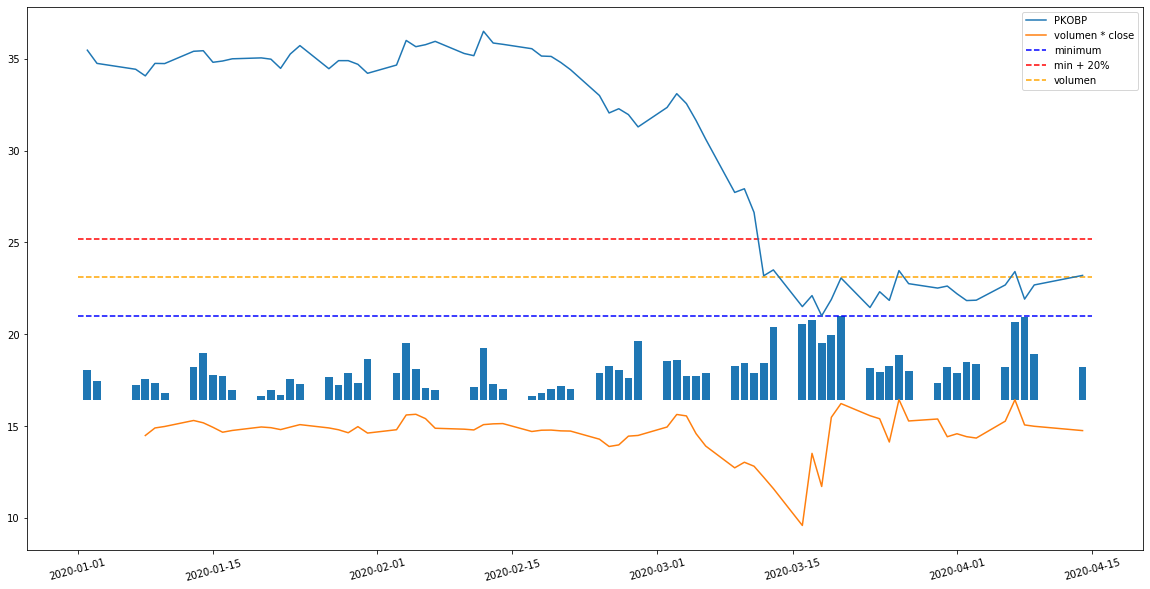

In [175]:
plot_paper(papier,'2020-01-01', str(date.today()))

In [145]:
(current,
data_max_before_crisis,
 data_crises_min,
 data_max_after_drop,
 data_min_after_max,
date_max_after_drop) = prepare_stats_forone(papier, before_crises, big_drop_date)

In [146]:
print(f'Paper: {papier}, currently at {current[0]}, with potential \
{round(data_max_before_crisis*100/current[0]-100, 2)}% to top')
print(f'Max before crisis: {data_max_before_crisis}')
print(f'Crisis bottom: {data_crises_min}')
print(f'Max after crisis drop: {data_max_after_drop}, at {date_max_after_drop[0]}')
print(f'Stats after Max: {data_min_after_max.values}')

Paper: PLAY, currently at 33.8, with potential 12.43% to top
Max before crisis: 38.0
Crisis bottom: 25.94
Max after crisis drop: 33.8, at 2020-04-09 00:00:00
Stats after Max: [33.8]


## Skaner

In [8]:
before_crisis = '2020-02-17'
top_bottom = '2020-03-12'
new_year = '2020-01-01'
last_y_quarter = '2019-10-01'
last_y_mid = '2019-06-03'

df_cols = [
    'ticker', 'current', 'before_crisis', 'last_y_q', 'last_y_mid',
    'crisis_bottom', 'max_after_crisis', 'max_before_crisis'
]

### All papers

In [9]:
skaner_df = pd.DataFrame(columns=df_cols)
for w in tqdm(all_stocks):
    
    df = prepare_data(w)
   
    skaner_df = pd.concat([skaner_df,
                       pd.DataFrame([[
                    df.TICKER[0],
                    df.loc[:,'CLOSE'].tail(1).values[0],
                    df.loc[df.index == before_crisis ,'CLOSE'].max(),
                    df.loc[df.index == last_y_quarter ,'CLOSE'].max(),
                           df.loc[df.index == last_y_mid,'CLOSE'].max(),
                    df.loc[(df.index >= top_bottom) & (df.index <= today),'CLOSE'].min(),
                    df.loc[df.index > top_bottom ,'CLOSE'].max(),
                    df.loc[(df.index >= last_y_quarter) & (df.index <= before_crisis),'CLOSE'].max()
                    
                       ]],
                                    columns=df_cols)], axis = 0)

100%|██████████| 1967/1967 [00:11<00:00, 171.46it/s]


In [10]:
skaner_df.loc[:,'growth_quarter'] = round(skaner_df.loc[:,'before_crisis'] * 100 / skaner_df.loc[:,'last_y_q'] - 100, 2)
skaner_df.loc[:,'growth_mid'] = round(skaner_df.loc[:,'last_y_q'] * 100 / skaner_df.loc[:,'last_y_mid'] - 100, 2)
skaner_df.loc[:,'growth_from_crisis'] = round(skaner_df.loc[:,'max_after_crisis'] * 100 / skaner_df.loc[:,'crisis_bottom'] - 100, 2)
skaner_df.loc[:,'growth_current'] = round(skaner_df.loc[:,'current'] * 100 / skaner_df.loc[:,'crisis_bottom'] - 100, 2)
skaner_df.loc[:,'growth_potential'] = round((skaner_df.loc[:,'max_before_crisis'] * 100) / skaner_df.loc[:,'current'] - 100, 2)
skaner_df.loc[:,'drop_current'] = round(skaner_df.loc[:,'current'] * 100 / skaner_df.loc[:,'max_before_crisis'] - 100, 2)

In [11]:
skaner_df_see = skaner_df.loc[
    #(skaner_df.growth_quarter > 0) 
        #& (skaner_df.growth_mid > 0) 
        #& (skaner_df.drop_current < 0) 
        (skaner_df.growth_current > 0)
                              ,:].sort_values('drop_current', ascending=True)

In [12]:
skaner_df_see = skaner_df_see.loc[
    skaner_df_see.ticker.apply(lambda x: 
                               False if ('RCFL' in x) 
                               | ('INTLGLD' in x) 
                               | ('RCFS' in x)
                               | ('INTL' in x)
                               | ('INTS' in x)
                               | ('RCTL' in x)
                               | ('BETA' in x)
                               | ('RCL' in x) else True).values,]

In [13]:
skaner_df_see.shape

(486, 14)

## Monitoring

In [89]:
to_monitor_list = ['ASBIS', 'UNIMOT',
            'CLNPHARMA', 'SUNEX', 
            'ELKOP', 'ABPL', 
            'MLSYSTEM',
            'AMBRA', 'INTERAOLT', 
            'LENA', 'ARCHICOM', 
            'KREC', 'INTERCARS', 'WIRTUALNA',
            'PLAY', 'MOSTALPLC', 'WIELTON']

In [90]:
df_merged = prepare_data(to_monitor_list[0]).loc[:,['CLOSE', 'TICKER', 'VOL']].copy()
df_merged = df_merged.loc[df_merged.index >= '2020-01-01'].copy()
df_merged.loc[:,'CLOSE'] = ((df_merged.loc[:,'CLOSE'] - df_merged.loc[:,'CLOSE'].mean()) 
                            / df_merged.loc[:,'CLOSE'].std())
df_merged.loc[:,'VOL'] = ((df_merged.loc[:,'VOL'] - df_merged.loc[:,'VOL'].mean()) 
                            / df_merged.loc[:,'VOL'].std())

In [91]:
for a in tqdm(to_monitor_list[1:]):

    df = prepare_data(a)
    df = df.loc[df.index >= '2020-01-01', ['CLOSE', 'TICKER', 'VOL']].copy()
    df.loc[:,'CLOSE'] = ((df.loc[:,'CLOSE'] - df.loc[:,'CLOSE'].mean()) 
                                / df.loc[:,'CLOSE'].std())
    df.loc[:,'VOL'] = ((df.loc[:,'VOL'] - df.loc[:,'VOL'].mean()) 
                                / df.loc[:,'VOL'].std())
        
    df_merged = pd.merge(df_merged, df,
                     left_index=True,
                     right_index=True,
                        how = 'outer')

100%|██████████| 16/16 [00:00<00:00, 79.36it/s]


In [92]:
df_stats = pd.DataFrame()

In [93]:
for t in ['CLOSE', 'VOL']:
    df_merged_limited = df_merged.loc[:, [c for c in df_merged.columns if t in c]]
    df_stats.loc[:,f'{t}_sum'] = df_merged_limited.sum(axis = 1)
    df_stats.loc[:,f'{t}_std'] = df_merged_limited.std(axis = 1)
    df_stats.loc[:,f'{t}_mean'] = df_merged_limited.mean(axis = 1)
    df_stats.loc[:,f'{t}_median'] = df_merged_limited.median(axis = 1)
    df_stats.loc[:,f'{t}_q90'] = df_merged_limited.quantile(0.9,axis = 1)
    df_stats.loc[:,f'{t}_q10'] = df_merged_limited.quantile(0.1,axis = 1)

In [94]:
for n in [5, 20]:
    
    df_stats.loc[:,f'CLOSE_mean_rolling{n}'] = df_stats.loc[:,'CLOSE_mean'].rolling(n).mean()
    df_stats.loc[:,f'VOL_mean_rolling{n}'] = df_stats.loc[:,'VOL_mean'].rolling(n).mean()

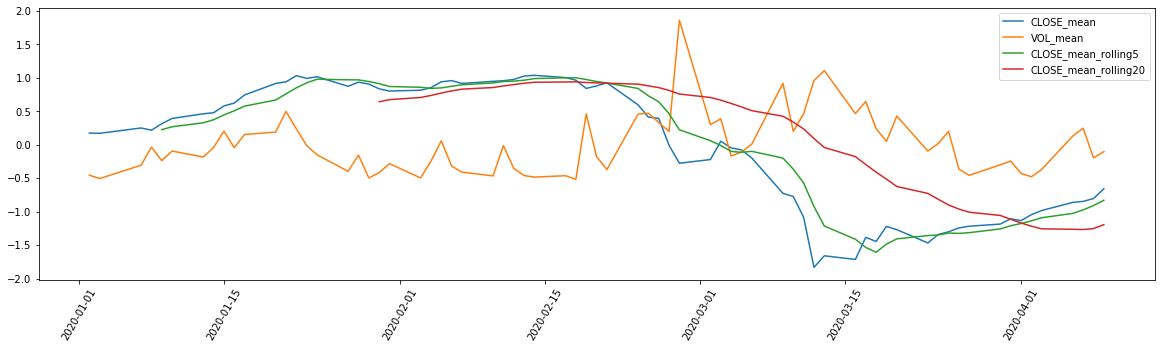

In [95]:
plt.figure(figsize=(20,5))
cols_to_plot = ['CLOSE_mean', 'VOL_mean',
                        'CLOSE_mean_rolling5',
                        'CLOSE_mean_rolling20']
plt.plot(df_stats.loc[:,cols_to_plot])
plt.xticks(rotation=60)
plt.legend(cols_to_plot)

## Model

In [14]:
### ADD WIG20 DAY BEFORE!

def transform_one_paper_ch(df):
    
    for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
        df.loc[:,col + '_shifted'] = df.loc[:,col].shift(1)
        df.loc[:,'chng_' + col] = np.nan
        df.loc[:,'chng_' + col] = (df.loc[:,col] * 100 / df.loc[:,col + '_shifted']) - 100
        
    df.loc[:,'move_strength_abs'] =  abs(df.loc[:,'chng_CLOSE']) * abs(df.loc[:,'chng_VOL'])
    df.loc[:,'move_strength'] =  (df.loc[:,'chng_CLOSE']) * (df.loc[:,'chng_VOL'])
    
    
### COMPARISON SECTION
#are you on losing strike?
#str strike
    for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
        for i in [5,10,20,30,60]:
            df.loc[:,f'comp{i}d_max' + col] = df.loc[:,col].rolling(i).max()
            df.loc[:,f'comp{i}d_max' + col] = (df.loc[:,col] * 100 / df.loc[:,f'comp{i}d_max' + col]) - 100
            
            df.loc[:,f'comp{i}d_min' + col] = df.loc[:,col].rolling(i).min()
            df.loc[:,f'comp{i}d_min' + col] = (df.loc[:,col] * 100 / df.loc[:,f'comp{i}d_min' + col]) - 100
            
            df.loc[:,f'comp{i}d_mean' + col] = df.loc[:,col].rolling(i).mean()
            df.loc[:,f'comp{i}d_mean' + col] = (df.loc[:,col] * 100 / df.loc[:,f'comp{i}d_mean' + col]) - 100
            
            df.loc[:,f'comp{i}d_std' + col] = df.loc[:,col].rolling(i).std()
            df.loc[:,f'comp{i}d_std' + col] = (df.loc[:,col] * 100 / df.loc[:,f'comp{i}d_std' + col]) - 100
            
    
#     for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
#         cols = [f'comp{i}d_max' + col for i in [5,10,20]]
#         #df.loc[:,'all_higher_f'] = (df[cols] > 0).sum(axis = 1)
#         df.loc[:,'all_higher_cat'] = (df[cols] > 0).astype(str).sum(axis = 1)
        
#         cols = [f'comp{i}d_min' + col for i in [5,10,20]]
#         #df.loc[:,'all_lower_f'] = (df[cols] < 0).sum(axis = 1)
#         df.loc[:,'all_lower_cat'] = (df[cols] < 0).astype(str).sum(axis = 1)
    
            
### FUTURE SECTION ###

#     df.loc[df.loc[:, 'OPEN'].shift(-1) > df.loc[:, 'CLOSE'],'fut_CLOSE_OPEN1'] = 1
#     df.loc[df.loc[:, 'OPEN'].shift(-1) <= df.loc[:, 'CLOSE'],'fut_CLOSE_OPEN1'] = 0
    
    #df.loc[:, 'fut_OPEN_CLOSE_chng'] = (df.loc[:, 'OPEN'].shift(-1) * 100 / df.loc[:, 'CLOSE']) - 100
    
#     df.loc[:, 'chng_rel_OPEN'] = np.nan
#     df.loc[df.loc[:, 'HIGH'] > df.loc[:, 'OPEN'] * 1.01,'chng_rel_OPEN'] = 1
#     df.loc[df.loc[:, 'HIGH'] <= df.loc[:, 'OPEN'] * 1.01, 'chng_rel_OPEN'] = 0
    
#     df.loc[df.loc[:, 'OPEN'] < df.loc[:, 'HIGH'],'comp_HIGH_OPEN'] = 1
#     df.loc[df.loc[:, 'OPEN'] >= df.loc[:, 'HIGH'],'comp_HIGH_OPEN'] = 0


### DIFFS SECTION ###
    df.loc[:,'diff_LOW_HIGH'] = (df.loc[:,'HIGH'] - df.loc[:,'LOW']) / df.loc[:,'HIGH']
    df.loc[:,'diff_OPEN_CLOSE'] = (df.loc[:,'OPEN'] - df.loc[:,'CLOSE']) / df.loc[:,'CLOSE']
    df.loc[:,'diff_LOW_CLOSE'] = (df.loc[:,'CLOSE'] - df.loc[:,'LOW']) / df.loc[:,'CLOSE']
    df.loc[:,'diff_HIGH_CLOSE'] = (df.loc[:,'HIGH'] - df.loc[:,'CLOSE']) / df.loc[:,'CLOSE']
    
    
### HISTORIC SECTION ###

    for a in [c for c in df.columns if ('diff_' in c) | ('chng' in c) | ('chng_' in c)]:
        for i in [1, 2, 3]:
            df.loc[:,f'hist{i}_' + a] = df.loc[:,a].shift(i)

### GET SOME MEANS ###
#Trye min and maxes and some std?
    for b in [c for c in df.columns if (('chng_' in c) 
                                        | ('move_' in c) 
                                        | ('diff_' in c)
                                       | ('same_' in c)) & ('hist' not in c)]:
        for g in [2, 3, 5, 10, 20]:
            df.loc[:,f'roll{g}m_' + b] = df.loc[:,b].rolling(g).mean()
            df.loc[:,f'roll{g}min_' + b] = df.loc[:,b].rolling(g).min()
            df.loc[:,f'roll{g}max_' + b] = df.loc[:,b].rolling(g).max()
            df.loc[:,f'roll{g}std_' + b] = df.loc[:,b].rolling(g).std()


### SUBTARGET ###
#     df.loc[df.loc[:, 'OPEN'].shift(-1) > df.loc[:, 'CLOSE'],'subtarget'] = 1
#     df.loc[df.loc[:, 'OPEN'].shift(-1) <= df.loc[:, 'CLOSE'],'subtarget'] = 0
            
### TARGET SECTION ###
#pick one the of the available sections

## HIGHER HIGH ###
#     df.loc[df.loc[:, 'HIGH'].shift(-1) > df.loc[:, 'HIGH'],'target'] = 1
#     df.loc[df.loc[:, 'HIGH'].shift(-1) <= df.loc[:, 'HIGH'],'target'] = 0

### LOWER LOW ###
#     df.loc[df.loc[:, 'LOW'].shift(-1) < df.loc[:, 'LOW'],'target'] = 1
#     df.loc[df.loc[:, 'LOW'].shift(-1) >= df.loc[:, 'LOW'],'target'] = 0
    
### HIGHER OPENING ###
#     df.loc[df.loc[:, 'OPEN'].shift(-1) > df.loc[:, 'CLOSE'],'target'] = 1
#     df.loc[df.loc[:, 'OPEN'].shift(-1) <= df.loc[:, 'CLOSE'],'target'] = 0
    
# ### HIGHER CLOSING THAN OPENING ###
#     df.loc[df.loc[:, 'CLOSE'].shift(-1) > df.loc[:, 'OPEN'].shift(-1),'target'] = 1
#     df.loc[df.loc[:, 'CLOSE'].shift(-1) <= df.loc[:, 'OPEN'].shift(-1),'target'] = 0

### OPENING NOT FAR FROM LOW ###
#     df.loc[df.loc[:, 'OPEN'].shift(-1)*0.995 > df.loc[:, 'LOW'].shift(-1),'target'] = 0
#     df.loc[df.loc[:, 'OPEN'].shift(-1)*0.995 <= df.loc[:, 'LOW'].shift(-1),'target'] = 1
    
### HIGH HIGHER MORE THAN 1% THAN OPENING ###
    df.loc[df.loc[:, 'OPEN'].shift(-1)*1.01 < df.loc[:, 'HIGH'].shift(-1),'target'] = 1
    df.loc[df.loc[:, 'OPEN'].shift(-1)*1.01 >=  df.loc[:, 'HIGH'].shift(-1),'target'] = 0
    
    return df

def transform_one_index(df):
    for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
        df.loc[:,col + '_shifted'] = df.loc[:,col].shift(1)
        df.loc[:,'chng_' + col] = np.nan
        df.loc[:,'chng_' + col] = (df.loc[:,col] * 100 / df.loc[:,col + '_shifted']) - 100
    return df

In [15]:
def f(q, res):
    while not (q.empty()):
        pap = q.get()
        df = prepare_data(pap)
        df = transform_one_paper_ch(df) 
        df = df.dropna()
        res.put(df)
    #print('done')
    
    
def put_res_together(resfin, res):
    
    while not (res.empty()):
        df_tofin = pd.DataFrame()
        #print(res.qsize())
        for i in range(10):
            try:
                df_one = res.get()
                df_tofin = pd.concat([df_tofin, df_one])
            except:
                resfin.put(df_tofin)
                break
        resfin.put(df_tofin)    
    #print('done')

In [16]:
q = Queue()
res = Queue()
resfin = Queue()

papers_to_train = list(watch + list(skaner_df_see.ticker.values))
papers_to_train = list(dict.fromkeys(papers_to_train ))

for w in (papers_to_train):
    q.put(w)

In [17]:
%%time

full_size = q.qsize()
total = q.qsize()
pbar = tqdm(total = total)

p = Process(target=f, args=(q, res))
p2 = Process(target=f, args=(q, res))
p3 = Process(target=f, args=(q, res))
p4 = Process(target=f, args=(q, res))
p5 = Process(target=f, args=(q, res))
p.start()
p2.start()
p3.start()
p4.start()
p5.start()


while (res.qsize() != full_size):
    if total > q.qsize():
        pbar.update(1)
        total = q.qsize()
pbar.close()

 99%|█████████▉| 482/486 [02:10<00:01,  3.68it/s]

CPU times: user 2min 9s, sys: 144 ms, total: 2min 9s
Wall time: 2min 10s


In [18]:
pt = Process(target=put_res_together, args=(resfin, res))
pt2 = Process(target=put_res_together, args=(resfin, res))
pt3 = Process(target=put_res_together, args=(resfin, res))
pt4 = Process(target=put_res_together, args=(resfin, res))
pt.start()
pt2.start()
pt3.start()
pt4.start()

total = res.qsize()
pbar = tqdm(total = total)

while(res.qsize()):
    if total > res.qsize():
        pbar.update(1)
        total = res.qsize()
pbar.close()

100%|██████████| 485/485 [00:07<00:00, 61.25it/s]


In [19]:
df_merged = pd.DataFrame()

total = resfin.qsize()
pbar = tqdm(total = total)

while not resfin.empty():
    df = resfin.get()
    df_merged = pd.concat([df_merged, df])
    pbar.update(1)
pbar.close()

47it [01:12,  1.53s/it]                        


In [20]:
p.terminate()
p2.terminate()
p3.terminate()
p4.terminate()
p5.terminate()

pt.terminate()
pt2.terminate()
pt3.terminate()
pt4.terminate()


gc.collect()

257

In [21]:
df_indexes_merged = pd.DataFrame()

for p in tqdm(all_indekses):
    
    df = prepare_index(p)
    df = transform_one_index(df) 
    
    #df = df.dropna()
    
    df_indexes_merged = pd.concat([df_indexes_merged, df])
    del df

100%|██████████| 23/23 [00:00<00:00, 36.28it/s]


In [22]:
df_indexes_merged = df_indexes_merged.pivot_table(index='DTYYYYMMDD', columns='TICKER', values='chng_CLOSE')
df_indexes_merged = df_indexes_merged.agg(['mean', 'max', 'min', 'std'], axis = 1)
df_indexes_merged = df_indexes_merged.add_prefix('foreign_stocks_')

df_merged = df_merged.merge(df_indexes_merged, left_index=True, right_index=True, how = 'left')

In [23]:
train_cols = [c for c in df_merged.columns if ('chng' in c) | ('move' in c) 
              | ('comp' in c) | ('fut' in c) | ('diff' in c) | ('same' in c) | ('hist' in c)]

train_cols = train_cols + list(df_indexes_merged.columns)

#train_cols = ['all_lower_cat', 'all_higher_cat'] + train_cols

In [24]:
#train_cols = train_cols_limited

df = df_merged.copy()
#df = df.loc[df.index > '2007-01-01',:]

In [25]:
cut_date = '2020-03-13'
train_data = df.loc[df.index < cut_date,train_cols]
eval_data = df.loc[df.index >= cut_date,train_cols]
train_labels = df.loc[df.index < cut_date,'target'].values
eval_labels = df.loc[df.index >= cut_date,'target'].values

In [26]:
def get_model():
    # Initialize CatBoostClassifier
    model = CatBoostClassifier(iterations=10000,
                           learning_rate=0.05,
                           depth=3,
                          thread_count=4,
                          eval_metric='AUC',
                          task_type='GPU')
    return model

In [27]:
model = get_model()

In [28]:
model.fit(train_data, train_labels, #cat_features=[0, 1],
          eval_set=[(eval_data[:-1], eval_labels[:-1])],
         early_stopping_rounds=500, use_best_model=True)

0:	learn: 0.6700737	test: 0.6504709	best: 0.6504709 (0)	total: 24.9ms	remaining: 4m 9s
1:	learn: 0.6836936	test: 0.6659743	best: 0.6659743 (1)	total: 49.3ms	remaining: 4m 6s
2:	learn: 0.6863815	test: 0.6666256	best: 0.6666256 (2)	total: 74.1ms	remaining: 4m 6s
3:	learn: 0.6891566	test: 0.6676961	best: 0.6676961 (3)	total: 98.7ms	remaining: 4m 6s
4:	learn: 0.6921474	test: 0.6741376	best: 0.6741376 (4)	total: 124ms	remaining: 4m 6s
5:	learn: 0.6955281	test: 0.6796496	best: 0.6796496 (5)	total: 149ms	remaining: 4m 7s
6:	learn: 0.6955132	test: 0.6797855	best: 0.6797855 (6)	total: 173ms	remaining: 4m 7s
7:	learn: 0.6962732	test: 0.6774960	best: 0.6797855 (6)	total: 197ms	remaining: 4m 6s
8:	learn: 0.6964778	test: 0.6783063	best: 0.6797855 (6)	total: 220ms	remaining: 4m 4s
9:	learn: 0.6969524	test: 0.6798655	best: 0.6798655 (9)	total: 251ms	remaining: 4m 10s
10:	learn: 0.6979312	test: 0.6847863	best: 0.6847863 (10)	total: 276ms	remaining: 4m 10s
11:	learn: 0.6984349	test: 0.6855386	best: 0.6

97:	learn: 0.7119892	test: 0.7003942	best: 0.7003942 (97)	total: 2.14s	remaining: 3m 36s
98:	learn: 0.7120187	test: 0.7003810	best: 0.7003942 (97)	total: 2.16s	remaining: 3m 36s
99:	learn: 0.7120915	test: 0.7003302	best: 0.7003942 (97)	total: 2.18s	remaining: 3m 36s
100:	learn: 0.7121212	test: 0.7004783	best: 0.7004783 (100)	total: 2.2s	remaining: 3m 35s
101:	learn: 0.7121859	test: 0.7002944	best: 0.7004783 (100)	total: 2.22s	remaining: 3m 35s
102:	learn: 0.7122312	test: 0.7003659	best: 0.7004783 (100)	total: 2.25s	remaining: 3m 35s
103:	learn: 0.7122535	test: 0.7005422	best: 0.7005422 (103)	total: 2.26s	remaining: 3m 35s
104:	learn: 0.7122975	test: 0.7004158	best: 0.7005422 (103)	total: 2.28s	remaining: 3m 35s
105:	learn: 0.7123562	test: 0.7006218	best: 0.7006218 (105)	total: 2.3s	remaining: 3m 34s
106:	learn: 0.7124048	test: 0.7007514	best: 0.7007514 (106)	total: 2.32s	remaining: 3m 34s
107:	learn: 0.7124584	test: 0.7007611	best: 0.7007611 (107)	total: 2.34s	remaining: 3m 34s
108:	le

188:	learn: 0.7152769	test: 0.7019907	best: 0.7021561 (174)	total: 4.01s	remaining: 3m 28s
189:	learn: 0.7153049	test: 0.7019777	best: 0.7021561 (174)	total: 4.04s	remaining: 3m 28s
190:	learn: 0.7153378	test: 0.7019907	best: 0.7021561 (174)	total: 4.06s	remaining: 3m 28s
191:	learn: 0.7153626	test: 0.7019420	best: 0.7021561 (174)	total: 4.07s	remaining: 3m 28s
192:	learn: 0.7153916	test: 0.7019141	best: 0.7021561 (174)	total: 4.09s	remaining: 3m 28s
193:	learn: 0.7154093	test: 0.7020133	best: 0.7021561 (174)	total: 4.12s	remaining: 3m 28s
194:	learn: 0.7154314	test: 0.7019381	best: 0.7021561 (174)	total: 4.13s	remaining: 3m 27s
195:	learn: 0.7154588	test: 0.7019583	best: 0.7021561 (174)	total: 4.16s	remaining: 3m 27s
196:	learn: 0.7154797	test: 0.7019438	best: 0.7021561 (174)	total: 4.17s	remaining: 3m 27s
197:	learn: 0.7154984	test: 0.7020257	best: 0.7021561 (174)	total: 4.19s	remaining: 3m 27s
198:	learn: 0.7155150	test: 0.7020213	best: 0.7021561 (174)	total: 4.21s	remaining: 3m 27s

279:	learn: 0.7172586	test: 0.7031337	best: 0.7031337 (279)	total: 5.92s	remaining: 3m 25s
280:	learn: 0.7172776	test: 0.7031193	best: 0.7031337 (279)	total: 5.94s	remaining: 3m 25s
281:	learn: 0.7172977	test: 0.7031254	best: 0.7031337 (279)	total: 5.96s	remaining: 3m 25s
282:	learn: 0.7173179	test: 0.7031106	best: 0.7031337 (279)	total: 5.98s	remaining: 3m 25s
283:	learn: 0.7173343	test: 0.7031624	best: 0.7031624 (283)	total: 6s	remaining: 3m 25s
284:	learn: 0.7173592	test: 0.7031487	best: 0.7031624 (283)	total: 6.02s	remaining: 3m 25s
285:	learn: 0.7173733	test: 0.7031642	best: 0.7031642 (285)	total: 6.04s	remaining: 3m 25s
286:	learn: 0.7173912	test: 0.7031668	best: 0.7031668 (286)	total: 6.06s	remaining: 3m 25s
287:	learn: 0.7174054	test: 0.7032751	best: 0.7032751 (287)	total: 6.08s	remaining: 3m 25s
288:	learn: 0.7174217	test: 0.7033544	best: 0.7033544 (288)	total: 6.1s	remaining: 3m 25s
289:	learn: 0.7174451	test: 0.7033686	best: 0.7033686 (289)	total: 6.12s	remaining: 3m 25s
290

378:	learn: 0.7187924	test: 0.7049704	best: 0.7049785 (377)	total: 7.97s	remaining: 3m 22s
379:	learn: 0.7188047	test: 0.7049682	best: 0.7049785 (377)	total: 7.99s	remaining: 3m 22s
380:	learn: 0.7188206	test: 0.7049985	best: 0.7049985 (380)	total: 8.01s	remaining: 3m 22s
381:	learn: 0.7188339	test: 0.7049824	best: 0.7049985 (380)	total: 8.03s	remaining: 3m 22s
382:	learn: 0.7188455	test: 0.7049828	best: 0.7049985 (380)	total: 8.05s	remaining: 3m 22s
383:	learn: 0.7188555	test: 0.7049850	best: 0.7049985 (380)	total: 8.08s	remaining: 3m 22s
384:	learn: 0.7188724	test: 0.7050000	best: 0.7050000 (384)	total: 8.1s	remaining: 3m 22s
385:	learn: 0.7188861	test: 0.7049987	best: 0.7050000 (384)	total: 8.12s	remaining: 3m 22s
386:	learn: 0.7188947	test: 0.7049824	best: 0.7050000 (384)	total: 8.14s	remaining: 3m 22s
387:	learn: 0.7189061	test: 0.7049997	best: 0.7050000 (384)	total: 8.16s	remaining: 3m 22s
388:	learn: 0.7189194	test: 0.7049863	best: 0.7050000 (384)	total: 8.18s	remaining: 3m 22s


479:	learn: 0.7198868	test: 0.7062590	best: 0.7063161 (478)	total: 10.1s	remaining: 3m 19s
480:	learn: 0.7198967	test: 0.7062514	best: 0.7063161 (478)	total: 10.1s	remaining: 3m 19s
481:	learn: 0.7199060	test: 0.7062204	best: 0.7063161 (478)	total: 10.1s	remaining: 3m 19s
482:	learn: 0.7199128	test: 0.7061911	best: 0.7063161 (478)	total: 10.1s	remaining: 3m 19s
483:	learn: 0.7199211	test: 0.7061994	best: 0.7063161 (478)	total: 10.2s	remaining: 3m 19s
484:	learn: 0.7199268	test: 0.7061897	best: 0.7063161 (478)	total: 10.2s	remaining: 3m 19s
485:	learn: 0.7199417	test: 0.7061735	best: 0.7063161 (478)	total: 10.2s	remaining: 3m 19s
486:	learn: 0.7199554	test: 0.7062126	best: 0.7063161 (478)	total: 10.2s	remaining: 3m 19s
487:	learn: 0.7199658	test: 0.7062079	best: 0.7063161 (478)	total: 10.2s	remaining: 3m 19s
488:	learn: 0.7199812	test: 0.7061673	best: 0.7063161 (478)	total: 10.3s	remaining: 3m 19s
489:	learn: 0.7199911	test: 0.7061701	best: 0.7063161 (478)	total: 10.3s	remaining: 3m 19s

578:	learn: 0.7207679	test: 0.7065903	best: 0.7066687 (572)	total: 12.4s	remaining: 3m 21s
579:	learn: 0.7207769	test: 0.7065521	best: 0.7066687 (572)	total: 12.4s	remaining: 3m 21s
580:	learn: 0.7207835	test: 0.7065446	best: 0.7066687 (572)	total: 12.5s	remaining: 3m 21s
581:	learn: 0.7207890	test: 0.7065224	best: 0.7066687 (572)	total: 12.5s	remaining: 3m 21s
582:	learn: 0.7207954	test: 0.7065219	best: 0.7066687 (572)	total: 12.5s	remaining: 3m 21s
583:	learn: 0.7208050	test: 0.7064154	best: 0.7066687 (572)	total: 12.5s	remaining: 3m 21s
584:	learn: 0.7208122	test: 0.7064142	best: 0.7066687 (572)	total: 12.5s	remaining: 3m 21s
585:	learn: 0.7208222	test: 0.7064251	best: 0.7066687 (572)	total: 12.6s	remaining: 3m 21s
586:	learn: 0.7208313	test: 0.7064521	best: 0.7066687 (572)	total: 12.6s	remaining: 3m 21s
587:	learn: 0.7208370	test: 0.7064677	best: 0.7066687 (572)	total: 12.6s	remaining: 3m 21s
588:	learn: 0.7208416	test: 0.7064720	best: 0.7066687 (572)	total: 12.6s	remaining: 3m 21s

672:	learn: 0.7214398	test: 0.7073843	best: 0.7073843 (672)	total: 14.5s	remaining: 3m 21s
673:	learn: 0.7214419	test: 0.7074044	best: 0.7074044 (673)	total: 14.5s	remaining: 3m 21s
674:	learn: 0.7214450	test: 0.7074041	best: 0.7074044 (673)	total: 14.6s	remaining: 3m 21s
675:	learn: 0.7214499	test: 0.7074193	best: 0.7074193 (675)	total: 14.6s	remaining: 3m 21s
676:	learn: 0.7214530	test: 0.7074293	best: 0.7074293 (676)	total: 14.6s	remaining: 3m 21s
677:	learn: 0.7214578	test: 0.7074238	best: 0.7074293 (676)	total: 14.6s	remaining: 3m 21s
678:	learn: 0.7214604	test: 0.7074170	best: 0.7074293 (676)	total: 14.7s	remaining: 3m 21s
679:	learn: 0.7214657	test: 0.7074358	best: 0.7074358 (679)	total: 14.7s	remaining: 3m 21s
680:	learn: 0.7214745	test: 0.7074450	best: 0.7074450 (680)	total: 14.7s	remaining: 3m 21s
681:	learn: 0.7214785	test: 0.7074577	best: 0.7074577 (681)	total: 14.7s	remaining: 3m 21s
682:	learn: 0.7214875	test: 0.7074481	best: 0.7074577 (681)	total: 14.7s	remaining: 3m 21s

770:	learn: 0.7219948	test: 0.7076491	best: 0.7078137 (734)	total: 16.8s	remaining: 3m 21s
771:	learn: 0.7219988	test: 0.7076648	best: 0.7078137 (734)	total: 16.9s	remaining: 3m 21s
772:	learn: 0.7220049	test: 0.7076696	best: 0.7078137 (734)	total: 16.9s	remaining: 3m 21s
773:	learn: 0.7220092	test: 0.7077263	best: 0.7078137 (734)	total: 16.9s	remaining: 3m 21s
774:	learn: 0.7220131	test: 0.7077136	best: 0.7078137 (734)	total: 16.9s	remaining: 3m 21s
775:	learn: 0.7220157	test: 0.7077234	best: 0.7078137 (734)	total: 16.9s	remaining: 3m 21s
776:	learn: 0.7220216	test: 0.7077711	best: 0.7078137 (734)	total: 17s	remaining: 3m 21s
777:	learn: 0.7220262	test: 0.7078006	best: 0.7078137 (734)	total: 17s	remaining: 3m 21s
778:	learn: 0.7220299	test: 0.7078059	best: 0.7078137 (734)	total: 17s	remaining: 3m 21s
779:	learn: 0.7220342	test: 0.7078024	best: 0.7078137 (734)	total: 17s	remaining: 3m 21s
780:	learn: 0.7220443	test: 0.7077856	best: 0.7078137 (734)	total: 17.1s	remaining: 3m 21s
781:	le

865:	learn: 0.7224910	test: 0.7081898	best: 0.7082294 (846)	total: 19.2s	remaining: 3m 22s
866:	learn: 0.7224933	test: 0.7081952	best: 0.7082294 (846)	total: 19.2s	remaining: 3m 22s
867:	learn: 0.7224964	test: 0.7081987	best: 0.7082294 (846)	total: 19.2s	remaining: 3m 22s
868:	learn: 0.7225013	test: 0.7081783	best: 0.7082294 (846)	total: 19.2s	remaining: 3m 22s
869:	learn: 0.7225033	test: 0.7081825	best: 0.7082294 (846)	total: 19.3s	remaining: 3m 22s
870:	learn: 0.7225105	test: 0.7081875	best: 0.7082294 (846)	total: 19.3s	remaining: 3m 22s
871:	learn: 0.7225131	test: 0.7082095	best: 0.7082294 (846)	total: 19.3s	remaining: 3m 21s
872:	learn: 0.7225175	test: 0.7082559	best: 0.7082559 (872)	total: 19.3s	remaining: 3m 21s
873:	learn: 0.7225226	test: 0.7082541	best: 0.7082559 (872)	total: 19.3s	remaining: 3m 21s
874:	learn: 0.7225293	test: 0.7082532	best: 0.7082559 (872)	total: 19.4s	remaining: 3m 21s
875:	learn: 0.7225353	test: 0.7082487	best: 0.7082559 (872)	total: 19.4s	remaining: 3m 21s

961:	learn: 0.7229236	test: 0.7087681	best: 0.7087799 (959)	total: 21.3s	remaining: 3m 19s
962:	learn: 0.7229276	test: 0.7087487	best: 0.7087799 (959)	total: 21.3s	remaining: 3m 19s
963:	learn: 0.7229314	test: 0.7087422	best: 0.7087799 (959)	total: 21.3s	remaining: 3m 19s
964:	learn: 0.7229382	test: 0.7087486	best: 0.7087799 (959)	total: 21.3s	remaining: 3m 19s
965:	learn: 0.7229423	test: 0.7087519	best: 0.7087799 (959)	total: 21.3s	remaining: 3m 19s
966:	learn: 0.7229458	test: 0.7087486	best: 0.7087799 (959)	total: 21.4s	remaining: 3m 19s
967:	learn: 0.7229510	test: 0.7087953	best: 0.7087953 (967)	total: 21.4s	remaining: 3m 19s
968:	learn: 0.7229563	test: 0.7087991	best: 0.7087991 (968)	total: 21.4s	remaining: 3m 19s
969:	learn: 0.7229598	test: 0.7088107	best: 0.7088107 (969)	total: 21.4s	remaining: 3m 19s
970:	learn: 0.7229647	test: 0.7088104	best: 0.7088107 (969)	total: 21.4s	remaining: 3m 19s
971:	learn: 0.7229700	test: 0.7088097	best: 0.7088107 (969)	total: 21.5s	remaining: 3m 19s

1051:	learn: 0.7233076	test: 0.7087407	best: 0.7089123 (999)	total: 23.2s	remaining: 3m 16s
1052:	learn: 0.7233093	test: 0.7087422	best: 0.7089123 (999)	total: 23.2s	remaining: 3m 16s
1053:	learn: 0.7233118	test: 0.7087587	best: 0.7089123 (999)	total: 23.2s	remaining: 3m 16s
1054:	learn: 0.7233137	test: 0.7087596	best: 0.7089123 (999)	total: 23.2s	remaining: 3m 16s
1055:	learn: 0.7233199	test: 0.7087314	best: 0.7089123 (999)	total: 23.2s	remaining: 3m 16s
1056:	learn: 0.7233217	test: 0.7087555	best: 0.7089123 (999)	total: 23.3s	remaining: 3m 16s
1057:	learn: 0.7233242	test: 0.7087615	best: 0.7089123 (999)	total: 23.3s	remaining: 3m 16s
1058:	learn: 0.7233294	test: 0.7087620	best: 0.7089123 (999)	total: 23.3s	remaining: 3m 16s
1059:	learn: 0.7233323	test: 0.7087718	best: 0.7089123 (999)	total: 23.3s	remaining: 3m 16s
1060:	learn: 0.7233374	test: 0.7088141	best: 0.7089123 (999)	total: 23.3s	remaining: 3m 16s
1061:	learn: 0.7233412	test: 0.7088062	best: 0.7089123 (999)	total: 23.4s	remain

1141:	learn: 0.7236148	test: 0.7088903	best: 0.7089520 (1123)	total: 25s	remaining: 3m 14s
1142:	learn: 0.7236175	test: 0.7088840	best: 0.7089520 (1123)	total: 25s	remaining: 3m 14s
1143:	learn: 0.7236218	test: 0.7088813	best: 0.7089520 (1123)	total: 25.1s	remaining: 3m 14s
1144:	learn: 0.7236255	test: 0.7088864	best: 0.7089520 (1123)	total: 25.1s	remaining: 3m 14s
1145:	learn: 0.7236291	test: 0.7088897	best: 0.7089520 (1123)	total: 25.1s	remaining: 3m 14s
1146:	learn: 0.7236319	test: 0.7089112	best: 0.7089520 (1123)	total: 25.1s	remaining: 3m 13s
1147:	learn: 0.7236342	test: 0.7089588	best: 0.7089588 (1147)	total: 25.2s	remaining: 3m 13s
1148:	learn: 0.7236380	test: 0.7089099	best: 0.7089588 (1147)	total: 25.2s	remaining: 3m 13s
1149:	learn: 0.7236407	test: 0.7089142	best: 0.7089588 (1147)	total: 25.2s	remaining: 3m 13s
1150:	learn: 0.7236441	test: 0.7089092	best: 0.7089588 (1147)	total: 25.2s	remaining: 3m 13s
1151:	learn: 0.7236477	test: 0.7089022	best: 0.7089588 (1147)	total: 25.2s

1237:	learn: 0.7239400	test: 0.7089300	best: 0.7089700 (1162)	total: 27.1s	remaining: 3m 12s
1238:	learn: 0.7239432	test: 0.7089027	best: 0.7089700 (1162)	total: 27.2s	remaining: 3m 12s
1239:	learn: 0.7239457	test: 0.7089156	best: 0.7089700 (1162)	total: 27.2s	remaining: 3m 12s
1240:	learn: 0.7239497	test: 0.7089236	best: 0.7089700 (1162)	total: 27.2s	remaining: 3m 12s
1241:	learn: 0.7239535	test: 0.7089362	best: 0.7089700 (1162)	total: 27.3s	remaining: 3m 12s
1242:	learn: 0.7239563	test: 0.7089487	best: 0.7089700 (1162)	total: 27.3s	remaining: 3m 12s
1243:	learn: 0.7239586	test: 0.7089257	best: 0.7089700 (1162)	total: 27.3s	remaining: 3m 12s
1244:	learn: 0.7239637	test: 0.7089270	best: 0.7089700 (1162)	total: 27.3s	remaining: 3m 12s
1245:	learn: 0.7239662	test: 0.7089300	best: 0.7089700 (1162)	total: 27.4s	remaining: 3m 12s
1246:	learn: 0.7239708	test: 0.7089033	best: 0.7089700 (1162)	total: 27.4s	remaining: 3m 12s
1247:	learn: 0.7239735	test: 0.7088937	best: 0.7089700 (1162)	total: 2

1334:	learn: 0.7242575	test: 0.7089403	best: 0.7090217 (1299)	total: 29.4s	remaining: 3m 11s
1335:	learn: 0.7242586	test: 0.7089514	best: 0.7090217 (1299)	total: 29.5s	remaining: 3m 11s
1336:	learn: 0.7242627	test: 0.7089622	best: 0.7090217 (1299)	total: 29.5s	remaining: 3m 11s
1337:	learn: 0.7242671	test: 0.7089968	best: 0.7090217 (1299)	total: 29.5s	remaining: 3m 10s
1338:	learn: 0.7242694	test: 0.7089997	best: 0.7090217 (1299)	total: 29.5s	remaining: 3m 10s
1339:	learn: 0.7242726	test: 0.7090034	best: 0.7090217 (1299)	total: 29.5s	remaining: 3m 10s
1340:	learn: 0.7242752	test: 0.7090079	best: 0.7090217 (1299)	total: 29.6s	remaining: 3m 10s
1341:	learn: 0.7242767	test: 0.7089888	best: 0.7090217 (1299)	total: 29.6s	remaining: 3m 10s
1342:	learn: 0.7242811	test: 0.7089887	best: 0.7090217 (1299)	total: 29.6s	remaining: 3m 10s
1343:	learn: 0.7242831	test: 0.7089823	best: 0.7090217 (1299)	total: 29.6s	remaining: 3m 10s
1344:	learn: 0.7242868	test: 0.7089836	best: 0.7090217 (1299)	total: 2

1429:	learn: 0.7245534	test: 0.7089447	best: 0.7091657 (1388)	total: 31.6s	remaining: 3m 9s
1430:	learn: 0.7245555	test: 0.7089440	best: 0.7091657 (1388)	total: 31.6s	remaining: 3m 9s
1431:	learn: 0.7245570	test: 0.7089347	best: 0.7091657 (1388)	total: 31.6s	remaining: 3m 9s
1432:	learn: 0.7245609	test: 0.7089399	best: 0.7091657 (1388)	total: 31.6s	remaining: 3m 9s
1433:	learn: 0.7245657	test: 0.7089348	best: 0.7091657 (1388)	total: 31.6s	remaining: 3m 9s
1434:	learn: 0.7245682	test: 0.7089200	best: 0.7091657 (1388)	total: 31.7s	remaining: 3m 9s
1435:	learn: 0.7245706	test: 0.7089276	best: 0.7091657 (1388)	total: 31.7s	remaining: 3m 9s
1436:	learn: 0.7245731	test: 0.7089355	best: 0.7091657 (1388)	total: 31.7s	remaining: 3m 9s
1437:	learn: 0.7245752	test: 0.7089243	best: 0.7091657 (1388)	total: 31.7s	remaining: 3m 9s
1438:	learn: 0.7245769	test: 0.7089286	best: 0.7091657 (1388)	total: 31.8s	remaining: 3m 9s
1439:	learn: 0.7245780	test: 0.7089208	best: 0.7091657 (1388)	total: 31.8s	remai

1526:	learn: 0.7248069	test: 0.7090760	best: 0.7091657 (1388)	total: 33.7s	remaining: 3m 6s
1527:	learn: 0.7248100	test: 0.7090872	best: 0.7091657 (1388)	total: 33.7s	remaining: 3m 6s
1528:	learn: 0.7248122	test: 0.7090909	best: 0.7091657 (1388)	total: 33.7s	remaining: 3m 6s
1529:	learn: 0.7248156	test: 0.7090724	best: 0.7091657 (1388)	total: 33.7s	remaining: 3m 6s
1530:	learn: 0.7248183	test: 0.7090678	best: 0.7091657 (1388)	total: 33.8s	remaining: 3m 6s
1531:	learn: 0.7248205	test: 0.7090648	best: 0.7091657 (1388)	total: 33.8s	remaining: 3m 6s
1532:	learn: 0.7248220	test: 0.7090636	best: 0.7091657 (1388)	total: 33.8s	remaining: 3m 6s
1533:	learn: 0.7248259	test: 0.7090489	best: 0.7091657 (1388)	total: 33.8s	remaining: 3m 6s
1534:	learn: 0.7248277	test: 0.7090474	best: 0.7091657 (1388)	total: 33.9s	remaining: 3m 6s
1535:	learn: 0.7248298	test: 0.7090514	best: 0.7091657 (1388)	total: 33.9s	remaining: 3m 6s
1536:	learn: 0.7248324	test: 0.7090504	best: 0.7091657 (1388)	total: 33.9s	remai

1616:	learn: 0.7250444	test: 0.7094210	best: 0.7094210 (1616)	total: 35.8s	remaining: 3m 5s
1617:	learn: 0.7250458	test: 0.7094181	best: 0.7094210 (1616)	total: 35.8s	remaining: 3m 5s
1618:	learn: 0.7250479	test: 0.7094148	best: 0.7094210 (1616)	total: 35.8s	remaining: 3m 5s
1619:	learn: 0.7250513	test: 0.7095202	best: 0.7095202 (1619)	total: 35.8s	remaining: 3m 5s
1620:	learn: 0.7250533	test: 0.7095199	best: 0.7095202 (1619)	total: 35.9s	remaining: 3m 5s
1621:	learn: 0.7250562	test: 0.7095224	best: 0.7095224 (1621)	total: 35.9s	remaining: 3m 5s
1622:	learn: 0.7250594	test: 0.7095213	best: 0.7095224 (1621)	total: 35.9s	remaining: 3m 5s
1623:	learn: 0.7250656	test: 0.7095411	best: 0.7095411 (1623)	total: 35.9s	remaining: 3m 5s
1624:	learn: 0.7250670	test: 0.7095354	best: 0.7095411 (1623)	total: 35.9s	remaining: 3m 5s
1625:	learn: 0.7250696	test: 0.7095384	best: 0.7095411 (1623)	total: 36s	remaining: 3m 5s
1626:	learn: 0.7250729	test: 0.7095255	best: 0.7095411 (1623)	total: 36s	remaining

1710:	learn: 0.7252816	test: 0.7096377	best: 0.7098300 (1701)	total: 37.9s	remaining: 3m 3s
1711:	learn: 0.7252841	test: 0.7096265	best: 0.7098300 (1701)	total: 37.9s	remaining: 3m 3s
1712:	learn: 0.7252866	test: 0.7096508	best: 0.7098300 (1701)	total: 37.9s	remaining: 3m 3s
1713:	learn: 0.7252882	test: 0.7096424	best: 0.7098300 (1701)	total: 37.9s	remaining: 3m 3s
1714:	learn: 0.7252900	test: 0.7096505	best: 0.7098300 (1701)	total: 38s	remaining: 3m 3s
1715:	learn: 0.7252940	test: 0.7096356	best: 0.7098300 (1701)	total: 38s	remaining: 3m 3s
1716:	learn: 0.7252970	test: 0.7096396	best: 0.7098300 (1701)	total: 38s	remaining: 3m 3s
1717:	learn: 0.7253015	test: 0.7096229	best: 0.7098300 (1701)	total: 38s	remaining: 3m 3s
1718:	learn: 0.7253028	test: 0.7096147	best: 0.7098300 (1701)	total: 38s	remaining: 3m 3s
1719:	learn: 0.7253049	test: 0.7096156	best: 0.7098300 (1701)	total: 38.1s	remaining: 3m 3s
1720:	learn: 0.7253082	test: 0.7096094	best: 0.7098300 (1701)	total: 38.1s	remaining: 3m 3

1803:	learn: 0.7255079	test: 0.7100680	best: 0.7100680 (1803)	total: 40s	remaining: 3m 1s
1804:	learn: 0.7255090	test: 0.7100762	best: 0.7100762 (1804)	total: 40s	remaining: 3m 1s
1805:	learn: 0.7255114	test: 0.7100667	best: 0.7100762 (1804)	total: 40s	remaining: 3m 1s
1806:	learn: 0.7255137	test: 0.7100790	best: 0.7100790 (1806)	total: 40s	remaining: 3m 1s
1807:	learn: 0.7255151	test: 0.7100711	best: 0.7100790 (1806)	total: 40.1s	remaining: 3m 1s
1808:	learn: 0.7255167	test: 0.7100856	best: 0.7100856 (1808)	total: 40.1s	remaining: 3m 1s
1809:	learn: 0.7255185	test: 0.7100816	best: 0.7100856 (1808)	total: 40.1s	remaining: 3m 1s
1810:	learn: 0.7255222	test: 0.7100728	best: 0.7100856 (1808)	total: 40.1s	remaining: 3m 1s
1811:	learn: 0.7255255	test: 0.7100652	best: 0.7100856 (1808)	total: 40.2s	remaining: 3m 1s
1812:	learn: 0.7255270	test: 0.7100631	best: 0.7100856 (1808)	total: 40.2s	remaining: 3m 1s
1813:	learn: 0.7255291	test: 0.7100814	best: 0.7100856 (1808)	total: 40.2s	remaining: 3m

1901:	learn: 0.7257375	test: 0.7098629	best: 0.7101039 (1858)	total: 42.3s	remaining: 3m
1902:	learn: 0.7257385	test: 0.7098842	best: 0.7101039 (1858)	total: 42.3s	remaining: 3m
1903:	learn: 0.7257417	test: 0.7098865	best: 0.7101039 (1858)	total: 42.3s	remaining: 2m 59s
1904:	learn: 0.7257425	test: 0.7098805	best: 0.7101039 (1858)	total: 42.4s	remaining: 2m 59s
1905:	learn: 0.7257443	test: 0.7098848	best: 0.7101039 (1858)	total: 42.4s	remaining: 2m 59s
1906:	learn: 0.7257460	test: 0.7098925	best: 0.7101039 (1858)	total: 42.4s	remaining: 2m 59s
1907:	learn: 0.7257491	test: 0.7098910	best: 0.7101039 (1858)	total: 42.4s	remaining: 2m 59s
1908:	learn: 0.7257515	test: 0.7098905	best: 0.7101039 (1858)	total: 42.4s	remaining: 2m 59s
1909:	learn: 0.7257541	test: 0.7098807	best: 0.7101039 (1858)	total: 42.5s	remaining: 2m 59s
1910:	learn: 0.7257571	test: 0.7098774	best: 0.7101039 (1858)	total: 42.5s	remaining: 2m 59s
1911:	learn: 0.7257581	test: 0.7098755	best: 0.7101039 (1858)	total: 42.5s	rem

1991:	learn: 0.7259328	test: 0.7099983	best: 0.7101039 (1858)	total: 44.4s	remaining: 2m 58s
1992:	learn: 0.7259355	test: 0.7100015	best: 0.7101039 (1858)	total: 44.4s	remaining: 2m 58s
1993:	learn: 0.7259387	test: 0.7099980	best: 0.7101039 (1858)	total: 44.4s	remaining: 2m 58s
1994:	learn: 0.7259420	test: 0.7100127	best: 0.7101039 (1858)	total: 44.5s	remaining: 2m 58s
1995:	learn: 0.7259438	test: 0.7100143	best: 0.7101039 (1858)	total: 44.5s	remaining: 2m 58s
1996:	learn: 0.7259450	test: 0.7100112	best: 0.7101039 (1858)	total: 44.5s	remaining: 2m 58s
1997:	learn: 0.7259474	test: 0.7100149	best: 0.7101039 (1858)	total: 44.5s	remaining: 2m 58s
1998:	learn: 0.7259504	test: 0.7100152	best: 0.7101039 (1858)	total: 44.6s	remaining: 2m 58s
1999:	learn: 0.7259522	test: 0.7099999	best: 0.7101039 (1858)	total: 44.6s	remaining: 2m 58s
2000:	learn: 0.7259541	test: 0.7099952	best: 0.7101039 (1858)	total: 44.6s	remaining: 2m 58s
2001:	learn: 0.7259562	test: 0.7100046	best: 0.7101039 (1858)	total: 4

2081:	learn: 0.7261378	test: 0.7101193	best: 0.7101682 (2043)	total: 46.5s	remaining: 2m 56s
2082:	learn: 0.7261409	test: 0.7101229	best: 0.7101682 (2043)	total: 46.5s	remaining: 2m 56s
2083:	learn: 0.7261426	test: 0.7101295	best: 0.7101682 (2043)	total: 46.6s	remaining: 2m 56s
2084:	learn: 0.7261442	test: 0.7101412	best: 0.7101682 (2043)	total: 46.6s	remaining: 2m 56s
2085:	learn: 0.7261471	test: 0.7101356	best: 0.7101682 (2043)	total: 46.6s	remaining: 2m 56s
2086:	learn: 0.7261502	test: 0.7101355	best: 0.7101682 (2043)	total: 46.6s	remaining: 2m 56s
2087:	learn: 0.7261523	test: 0.7101397	best: 0.7101682 (2043)	total: 46.7s	remaining: 2m 56s
2088:	learn: 0.7261536	test: 0.7101512	best: 0.7101682 (2043)	total: 46.7s	remaining: 2m 56s
2089:	learn: 0.7261556	test: 0.7101347	best: 0.7101682 (2043)	total: 46.7s	remaining: 2m 56s
2090:	learn: 0.7261577	test: 0.7101448	best: 0.7101682 (2043)	total: 46.7s	remaining: 2m 56s
2091:	learn: 0.7261598	test: 0.7101471	best: 0.7101682 (2043)	total: 4

2172:	learn: 0.7263424	test: 0.7101803	best: 0.7102595 (2140)	total: 48.6s	remaining: 2m 55s
2173:	learn: 0.7263445	test: 0.7101803	best: 0.7102595 (2140)	total: 48.7s	remaining: 2m 55s
2174:	learn: 0.7263471	test: 0.7101708	best: 0.7102595 (2140)	total: 48.7s	remaining: 2m 55s
2175:	learn: 0.7263489	test: 0.7101579	best: 0.7102595 (2140)	total: 48.7s	remaining: 2m 55s
2176:	learn: 0.7263507	test: 0.7101715	best: 0.7102595 (2140)	total: 48.7s	remaining: 2m 55s
2177:	learn: 0.7263524	test: 0.7101861	best: 0.7102595 (2140)	total: 48.7s	remaining: 2m 55s
2178:	learn: 0.7263535	test: 0.7101928	best: 0.7102595 (2140)	total: 48.8s	remaining: 2m 55s
2179:	learn: 0.7263554	test: 0.7101915	best: 0.7102595 (2140)	total: 48.8s	remaining: 2m 54s
2180:	learn: 0.7263597	test: 0.7101973	best: 0.7102595 (2140)	total: 48.8s	remaining: 2m 54s
2181:	learn: 0.7263620	test: 0.7101944	best: 0.7102595 (2140)	total: 48.8s	remaining: 2m 54s
2182:	learn: 0.7263636	test: 0.7101918	best: 0.7102595 (2140)	total: 4

2268:	learn: 0.7265326	test: 0.7104316	best: 0.7104316 (2268)	total: 50.7s	remaining: 2m 52s
2269:	learn: 0.7265359	test: 0.7103908	best: 0.7104316 (2268)	total: 50.8s	remaining: 2m 52s
2270:	learn: 0.7265391	test: 0.7103801	best: 0.7104316 (2268)	total: 50.8s	remaining: 2m 52s
2271:	learn: 0.7265421	test: 0.7103836	best: 0.7104316 (2268)	total: 50.8s	remaining: 2m 52s
2272:	learn: 0.7265444	test: 0.7104357	best: 0.7104357 (2272)	total: 50.8s	remaining: 2m 52s
2273:	learn: 0.7265457	test: 0.7104431	best: 0.7104431 (2273)	total: 50.9s	remaining: 2m 52s
2274:	learn: 0.7265493	test: 0.7104363	best: 0.7104431 (2273)	total: 50.9s	remaining: 2m 52s
2275:	learn: 0.7265503	test: 0.7104203	best: 0.7104431 (2273)	total: 50.9s	remaining: 2m 52s
2276:	learn: 0.7265516	test: 0.7104367	best: 0.7104431 (2273)	total: 50.9s	remaining: 2m 52s
2277:	learn: 0.7265556	test: 0.7104348	best: 0.7104431 (2273)	total: 50.9s	remaining: 2m 52s
2278:	learn: 0.7265574	test: 0.7104284	best: 0.7104431 (2273)	total: 5

2360:	learn: 0.7267324	test: 0.7105480	best: 0.7106068 (2352)	total: 52.9s	remaining: 2m 51s
2361:	learn: 0.7267343	test: 0.7105613	best: 0.7106068 (2352)	total: 52.9s	remaining: 2m 51s
2362:	learn: 0.7267362	test: 0.7105464	best: 0.7106068 (2352)	total: 52.9s	remaining: 2m 51s
2363:	learn: 0.7267395	test: 0.7105884	best: 0.7106068 (2352)	total: 52.9s	remaining: 2m 50s
2364:	learn: 0.7267433	test: 0.7105529	best: 0.7106068 (2352)	total: 53s	remaining: 2m 50s
2365:	learn: 0.7267443	test: 0.7105607	best: 0.7106068 (2352)	total: 53s	remaining: 2m 50s
2366:	learn: 0.7267476	test: 0.7105546	best: 0.7106068 (2352)	total: 53s	remaining: 2m 50s
2367:	learn: 0.7267500	test: 0.7105467	best: 0.7106068 (2352)	total: 53s	remaining: 2m 50s
2368:	learn: 0.7267534	test: 0.7105458	best: 0.7106068 (2352)	total: 53.1s	remaining: 2m 50s
2369:	learn: 0.7267547	test: 0.7105384	best: 0.7106068 (2352)	total: 53.1s	remaining: 2m 50s
2370:	learn: 0.7267565	test: 0.7105380	best: 0.7106068 (2352)	total: 53.1s	rem

2454:	learn: 0.7269234	test: 0.7104209	best: 0.7106068 (2352)	total: 55s	remaining: 2m 49s
2455:	learn: 0.7269254	test: 0.7104275	best: 0.7106068 (2352)	total: 55s	remaining: 2m 48s
2456:	learn: 0.7269265	test: 0.7104428	best: 0.7106068 (2352)	total: 55s	remaining: 2m 48s
2457:	learn: 0.7269285	test: 0.7104484	best: 0.7106068 (2352)	total: 55.1s	remaining: 2m 48s
2458:	learn: 0.7269298	test: 0.7104578	best: 0.7106068 (2352)	total: 55.1s	remaining: 2m 48s
2459:	learn: 0.7269318	test: 0.7104638	best: 0.7106068 (2352)	total: 55.1s	remaining: 2m 48s
2460:	learn: 0.7269323	test: 0.7104553	best: 0.7106068 (2352)	total: 55.1s	remaining: 2m 48s
2461:	learn: 0.7269331	test: 0.7104522	best: 0.7106068 (2352)	total: 55.1s	remaining: 2m 48s
2462:	learn: 0.7269368	test: 0.7104424	best: 0.7106068 (2352)	total: 55.2s	remaining: 2m 48s
2463:	learn: 0.7269377	test: 0.7104429	best: 0.7106068 (2352)	total: 55.2s	remaining: 2m 48s
2464:	learn: 0.7269409	test: 0.7104323	best: 0.7106068 (2352)	total: 55.2s	r

2545:	learn: 0.7271035	test: 0.7103755	best: 0.7106068 (2352)	total: 56.9s	remaining: 2m 46s
2546:	learn: 0.7271048	test: 0.7103743	best: 0.7106068 (2352)	total: 56.9s	remaining: 2m 46s
2547:	learn: 0.7271073	test: 0.7103766	best: 0.7106068 (2352)	total: 56.9s	remaining: 2m 46s
2548:	learn: 0.7271092	test: 0.7103731	best: 0.7106068 (2352)	total: 56.9s	remaining: 2m 46s
2549:	learn: 0.7271115	test: 0.7103624	best: 0.7106068 (2352)	total: 56.9s	remaining: 2m 46s
2550:	learn: 0.7271120	test: 0.7103745	best: 0.7106068 (2352)	total: 57s	remaining: 2m 46s
2551:	learn: 0.7271134	test: 0.7103714	best: 0.7106068 (2352)	total: 57s	remaining: 2m 46s
2552:	learn: 0.7271153	test: 0.7103705	best: 0.7106068 (2352)	total: 57s	remaining: 2m 46s
2553:	learn: 0.7271170	test: 0.7103727	best: 0.7106068 (2352)	total: 57s	remaining: 2m 46s
2554:	learn: 0.7271193	test: 0.7103724	best: 0.7106068 (2352)	total: 57s	remaining: 2m 46s
2555:	learn: 0.7271220	test: 0.7103812	best: 0.7106068 (2352)	total: 57.1s	remai

2637:	learn: 0.7272857	test: 0.7104402	best: 0.7106068 (2352)	total: 58.7s	remaining: 2m 43s
2638:	learn: 0.7272875	test: 0.7104450	best: 0.7106068 (2352)	total: 58.8s	remaining: 2m 43s
2639:	learn: 0.7272896	test: 0.7104430	best: 0.7106068 (2352)	total: 58.8s	remaining: 2m 43s
2640:	learn: 0.7272907	test: 0.7104446	best: 0.7106068 (2352)	total: 58.8s	remaining: 2m 43s
2641:	learn: 0.7272922	test: 0.7104602	best: 0.7106068 (2352)	total: 58.8s	remaining: 2m 43s
2642:	learn: 0.7272943	test: 0.7104533	best: 0.7106068 (2352)	total: 58.8s	remaining: 2m 43s
2643:	learn: 0.7272955	test: 0.7104579	best: 0.7106068 (2352)	total: 58.9s	remaining: 2m 43s
2644:	learn: 0.7272969	test: 0.7104634	best: 0.7106068 (2352)	total: 58.9s	remaining: 2m 43s
2645:	learn: 0.7272997	test: 0.7104470	best: 0.7106068 (2352)	total: 58.9s	remaining: 2m 43s
2646:	learn: 0.7273021	test: 0.7104450	best: 0.7106068 (2352)	total: 58.9s	remaining: 2m 43s
2647:	learn: 0.7273046	test: 0.7104433	best: 0.7106068 (2352)	total: 5

2727:	learn: 0.7274535	test: 0.7102817	best: 0.7106068 (2352)	total: 1m	remaining: 2m 41s
2728:	learn: 0.7274556	test: 0.7102841	best: 0.7106068 (2352)	total: 1m	remaining: 2m 41s
2729:	learn: 0.7274562	test: 0.7102989	best: 0.7106068 (2352)	total: 1m	remaining: 2m 41s
2730:	learn: 0.7274584	test: 0.7102953	best: 0.7106068 (2352)	total: 1m	remaining: 2m 41s
2731:	learn: 0.7274599	test: 0.7103056	best: 0.7106068 (2352)	total: 1m	remaining: 2m 41s
2732:	learn: 0.7274610	test: 0.7103093	best: 0.7106068 (2352)	total: 1m	remaining: 2m 41s
2733:	learn: 0.7274626	test: 0.7103102	best: 0.7106068 (2352)	total: 1m	remaining: 2m 41s
2734:	learn: 0.7274635	test: 0.7103111	best: 0.7106068 (2352)	total: 1m	remaining: 2m 41s
2735:	learn: 0.7274649	test: 0.7103150	best: 0.7106068 (2352)	total: 1m	remaining: 2m 41s
2736:	learn: 0.7274665	test: 0.7103153	best: 0.7106068 (2352)	total: 1m	remaining: 2m 41s
2737:	learn: 0.7274684	test: 0.7103180	best: 0.7106068 (2352)	total: 1m	remaining: 2m 41s
2738:	lear

2819:	learn: 0.7276223	test: 0.7102115	best: 0.7106068 (2352)	total: 1m 2s	remaining: 2m 39s
2820:	learn: 0.7276233	test: 0.7102200	best: 0.7106068 (2352)	total: 1m 2s	remaining: 2m 39s
2821:	learn: 0.7276245	test: 0.7102236	best: 0.7106068 (2352)	total: 1m 2s	remaining: 2m 39s
2822:	learn: 0.7276263	test: 0.7102298	best: 0.7106068 (2352)	total: 1m 2s	remaining: 2m 39s
2823:	learn: 0.7276289	test: 0.7102275	best: 0.7106068 (2352)	total: 1m 2s	remaining: 2m 39s
2824:	learn: 0.7276294	test: 0.7102235	best: 0.7106068 (2352)	total: 1m 2s	remaining: 2m 38s
2825:	learn: 0.7276310	test: 0.7102225	best: 0.7106068 (2352)	total: 1m 2s	remaining: 2m 38s
2826:	learn: 0.7276332	test: 0.7102089	best: 0.7106068 (2352)	total: 1m 2s	remaining: 2m 38s
2827:	learn: 0.7276348	test: 0.7102091	best: 0.7106068 (2352)	total: 1m 2s	remaining: 2m 38s
2828:	learn: 0.7276362	test: 0.7102140	best: 0.7106068 (2352)	total: 1m 2s	remaining: 2m 38s
2829:	learn: 0.7276370	test: 0.7102390	best: 0.7106068 (2352)	total: 1

In [48]:
model.get_feature_importance(prettified=True).head(10)

,Feature Id,Importances
0,roll20std_diff_LOW_HIGH,11.294201
1,roll20m_diff_LOW_HIGH,6.946254
2,roll20m_diff_OPEN_CLOSE,5.042675
3,roll20min_diff_OPEN_CLOSE,4.328985
4,diff_LOW_HIGH,4.211962
5,roll20max_diff_LOW_HIGH,3.946873
6,roll10min_diff_OPEN_CLOSE,3.881866
7,roll20min_diff_LOW_HIGH,3.523642
8,roll20m_diff_HIGH_CLOSE,2.989512
9,roll10min_diff_LOW_HIGH,2.711623


In [30]:
working_feats_785_on_high = ['diff_HIGH_CLOSE', 'diff_OPEN_CLOSE','roll20min_diff_LOW_HIGH',
                     'chng_HIGH','roll2std_chng_HIGH',
                     'comp5d_stdHIGH','roll20min_chng_VOL','comp5d_meanOPEN','move_strength_abs',
                     'roll2min_chng_HIGH','roll3min_move_strength_abs']

imp = model.get_feature_importance(prettified=True)
train_cols_limited  = [c for c in train_cols if c in imp.loc[imp.Importances >= 0.01, 'Feature Id'].values]
#train_cols_limited = working_feats_785_on_high
len(train_cols) - len(train_cols_limited)

97

#### Analysis categorical

In [31]:
preds_class = model.predict(eval_data)
# Get predicted probabilities for each class
preds_proba = model.predict_proba(eval_data)
# Get predicted RawFormulaVal
preds_raw = model.predict(eval_data, prediction_type='RawFormulaVal')

preds = preds_class[:-1].astype(int)

In [44]:
preds = preds_proba[:,1].copy()

preds[preds > 0.75] = 1
preds[preds < 1] = 0
preds = preds[:-1].astype(int)

In [32]:
confusion_matrix(eval_labels[:-1].astype(int), preds)

array([[2725, 1883],
       [1368, 3414]])

In [33]:
tn, fp, fn, tp = confusion_matrix(eval_labels[:-1].astype(int), preds).ravel()
(tn, fp, fn, tp)

(2725, 1883, 1368, 3414)

In [34]:
(tn + tp) / (tn + tp + fp + fn)

0.6537806176783812

In [35]:
tp / (tp + fp)

0.6445157636397961

In [36]:
df_res = pd.concat([pd.DataFrame(preds_proba), pd.Series(eval_labels)], axis=1)
df_res.columns = ['zero', 'one', 'true']
df_res.groupby('true').mean()

,zero,one
true,,
0.0,0.565798,0.434202
1.0,0.428941,0.571059


In [37]:
df_res.loc[:,'one'] = df_res.loc[:,'one'].round(1)
df_res.loc[:,'zero'] = df_res.loc[:,'zero'].round(1)
df_res_grouped = df_res.drop('zero', axis = 1)

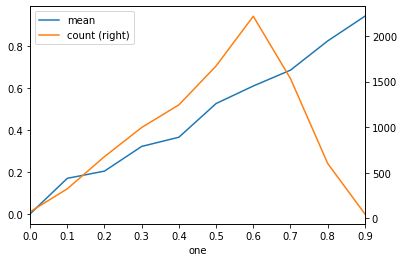

In [38]:
# df_res_grouped.loc[df_res_grouped.one <= 0.3,'one'] = 0.3
# df_res_grouped.loc[df_res_grouped.one >= 0.54,'one'] = 0.55
df_res_grouped = df_res_grouped.groupby('one').agg(['mean', 'count'])
df_res_grouped.columns = df_res_grouped.columns.get_level_values(1)
df_res_grouped = df_res_grouped.reset_index().set_index('one')

df_res_grouped.plot(secondary_y='count')
plt.xticks(rotation=60)
plt.show()

In [39]:
df_res_grouped

,mean,count
one,,
0.0,0.000000,73
0.1,0.169231,325
0.2,0.203540,678
0.3,0.320963,997
0.4,0.364659,1245
0.5,0.524835,1671
0.6,0.608303,2216
0.7,0.683627,1533
0.8,0.822554,603


### Prediction

#### Categorical

In [40]:
eval_data.loc[:,'target'] = eval_labels
eval_data.loc[:,'target'] = eval_data.loc[:,'target']
eval_data.loc[:,'pred_class'] = model.predict(eval_data[train_cols])

eval_data.loc[:,'pred_proba'] = model.predict_proba(eval_data[train_cols])[:,1]
eval_data.loc[:,'pred_proba'] = eval_data.loc[:,'pred_proba'].round(1)

#### Prediction for couple of papers

In [41]:
def transform_results(qpapers, qtransformed, model):
    while not (qpapers.empty()):
        pap = qpapers.get()
        #print(pap)
        df = prepare_data(pap)
        df = transform_one_paper_ch(df) 
        
        df = df.merge(df_indexes_merged,
              left_index=True,
              right_index=True,
              how='left')

        #df.loc[:, 'pred_class'] = model.predict(df[train_cols])
        df.loc[:, 'pred_prob'] = model.predict_proba(df[train_cols])[:, 1]

        df.loc[:, 'fut_OPEN'] = df.loc[:, 'OPEN'].shift(-1)
        df.loc[:, 'fut_CLOSE'] = df.loc[:, 'CLOSE'].shift(-1)
        df.loc[:, 'fut_LOW'] = df.loc[:, 'LOW'].shift(-1)
        df.loc[:, 'fut_HIGH'] = df.loc[:, 'HIGH'].shift(-1)
        
        df.loc[:, 'fOPEN_fHIGH_chng'] = (df.loc[:, 'fut_HIGH'] * 100 /
                                 df.loc[:, 'fut_OPEN']) - 100
        df.loc[:, 'fOPEN_fCLOSE_chng'] = (df.loc[:, 'fut_CLOSE'] * 100 /
                                 df.loc[:, 'fut_OPEN']) - 100
        df.loc[:, 'CLOSE_fOPEN_chng'] = (df.loc[:, 'fut_OPEN'] * 100 /
                                         df.loc[:, 'CLOSE']) - 100
        df.loc[:, 'HIGH_fHIGH_chng'] = (df.loc[:, 'fut_HIGH'] * 100 /
                         df.loc[:, 'HIGH']) - 100
        df.loc[:, 'LOW_fLOW_chng'] = (df.loc[:, 'fut_LOW'] * 100 /
                 df.loc[:, 'LOW']) - 100
    

        one_res = df.reset_index().loc[:, [
            'DTYYYYMMDD', 'TICKER', 'OPEN', 'LOW', 'HIGH', 'CLOSE', 
           'fOPEN_fHIGH_chng', 'fut_OPEN', 'fut_LOW', 'fut_HIGH', 'fut_CLOSE',
            'fOPEN_fCLOSE_chng', 'CLOSE_fOPEN_chng', 'HIGH_fHIGH_chng', 'LOW_fLOW_chng', 'pred_prob']
                                      ].tail(15)
    
        if one_res.shape == (15, 16):
            qtransformed.put(one_res)
    
    
def put_res_results_together(resfin, res):
    
    while not (res.empty()):
        df_tofin = pd.DataFrame()
        #print(res.qsize())
        for i in range(10):
            try:
                df_one = res.get()
                df_tofin = pd.concat([df_tofin, df_one])
            except:
                resfin.put(df_tofin)
                break
        resfin.put(df_tofin)    
    #print('done')

In [42]:
qpapers = Queue()
qtransformed = Queue()

for w in (skaner_df_see.dropna().ticker.values):
    qpapers.put(w)

In [43]:
total = qpapers.qsize()
full_size = qpapers.qsize()

#%%time
p = Process(target=transform_results, args=(qpapers, qtransformed, model))
p2 = Process(target=transform_results, args=(qpapers, qtransformed, model))
p3 = Process(target=transform_results, args=(qpapers, qtransformed, model))
p4 = Process(target=transform_results, args=(qpapers, qtransformed, model))
p5 = Process(target=transform_results, args=(qpapers, qtransformed, model))
p.start()
p2.start()
p3.start()
p4.start()
p5.start()


pbar = tqdm(total = total)

while qtransformed.qsize() != full_size:
    if total > qpapers.qsize():
        pbar.update(1)
        #print(total)
        total = qpapers.qsize()
pbar.close()

  7%|▋         | 26/347 [00:09<02:30,  2.13it/s]/home/showletter/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
 98%|█████████▊| 341/347 [01:56<00:02,  2.92it/s]


In [44]:
res = pd.DataFrame()
for i in tqdm(range(qtransformed.qsize())):
    df = qtransformed.get()
    #print(df.TICKER.values[0])
    res = pd.concat([res, df])
    #print(res.shape)

100%|██████████| 347/347 [00:00<00:00, 775.82it/s]


In [45]:
p.terminate()
p2.terminate()
p3.terminate()
p4.terminate()
p5.terminate()

In [46]:
res.loc[:,'DTYYYYMMDD'] = pd.to_datetime(res.DTYYYYMMDD)

In [56]:
res.loc[res.DTYYYYMMDD == '2020-04-17'].sort_values('pred_prob', ascending=False).head(100)

,DTYYYYMMDD,TICKER,OPEN,LOW,HIGH,CLOSE,fOPEN_fHIGH_chng,fut_OPEN,fut_LOW,fut_HIGH,fut_CLOSE,fOPEN_fCLOSE_chng,CLOSE_fOPEN_chng,HIGH_fHIGH_chng,LOW_fLOW_chng,pred_prob
1010,2020-04-17,SETANTA,7.7600,7.7600,10.0000,9.820,7.881773,10.1500,9.200,10.9500,10.8500,6.896552,3.360489,9.500000,18.556701,0.815747
3422,2020-04-17,ACTION,2.7900,2.7900,3.1500,2.970,23.809524,3.1500,3.070,3.9000,3.9000,23.809524,6.060606,23.809524,10.035842,0.794863
641,2020-04-17,XTPL,79.0000,77.0000,87.0000,87.000,9.576837,89.8000,88.000,98.4000,91.0000,1.336303,3.218391,13.103448,14.285714,0.771882
2042,2020-04-17,BIOMEDLUB,3.4200,3.0800,3.5600,3.220,0.000000,3.3000,2.860,3.3000,2.9200,-11.515152,2.484472,-7.303371,-7.142857,0.756375
3181,2020-04-17,KOMPUTRON,1.9800,1.9500,2.6000,2.550,20.588235,2.7200,2.720,3.2800,3.2800,20.588235,6.666667,26.153846,39.487179,0.739672
2851,2020-04-17,ENEA,5.4800,5.4550,5.9600,5.900,7.588533,5.9300,5.640,6.3800,6.1500,3.709949,0.508475,7.046980,3.391384,0.735282
2659,2020-04-17,TESGAS,3.7400,3.7400,4.1000,3.760,7.329843,3.8200,3.820,4.1000,4.0400,5.759162,1.595745,0.000000,2.139037,0.716836
5730,2020-04-17,LUBAWA,1.3100,1.2200,1.3100,1.230,0.000000,1.2500,1.200,1.2500,1.2200,-2.400000,1.626016,-4.580153,-1.639344,0.715320
2860,2020-04-17,QUERCUS,2.4500,2.4500,2.6400,2.580,0.000000,2.6500,2.480,2.6500,2.5100,-5.283019,2.713178,0.378788,1.224490,0.712252
1737,2020-04-17,GRODNO,4.5800,4.2300,4.5800,4.310,4.408353,4.3100,4.310,4.5000,4.4400,3.016241,0.000000,-1.746725,1.891253,0.706105


In [55]:
res.loc[res.DTYYYYMMDD == '2020-04-20'].sort_values('pred_prob', ascending=False).head(100)

,DTYYYYMMDD,TICKER,OPEN,LOW,HIGH,CLOSE,fOPEN_fHIGH_chng,fut_OPEN,fut_LOW,fut_HIGH,fut_CLOSE,fOPEN_fCLOSE_chng,CLOSE_fOPEN_chng,HIGH_fHIGH_chng,LOW_fLOW_chng,pred_prob
3423,2020-04-20,ACTION,3.150,3.070,3.900,3.900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.871560
6467,2020-04-20,RAFAKO,0.539,0.535,0.650,0.650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.843521
2043,2020-04-20,BIOMEDLUB,3.300,2.860,3.300,2.920,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.830610
1011,2020-04-20,SETANTA,10.150,9.200,10.950,10.850,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.824135
1545,2020-04-20,MERCATOR,34.000,34.000,39.300,38.200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.810028
457,2020-04-20,ULTGAMES,21.350,21.050,24.450,23.950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.809436
1808,2020-04-20,DATAWALK,45.600,44.000,52.400,50.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.807515
3182,2020-04-20,KOMPUTRON,2.720,2.720,3.280,3.280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.800630
5588,2020-04-20,POLIMEXMS,2.225,2.000,2.225,2.030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.795502
5729,2020-04-20,COGNOR,0.900,0.900,1.045,0.980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.794208


In [59]:
res.mean()

OPEN                 685.375359
LOW                  676.506040
HIGH                 694.751174
CLOSE                686.743353
fOPEN_fHIGH_chng       2.751337
fut_OPEN             687.864534
fut_LOW              679.080129
fut_HIGH             697.683273
fut_CLOSE            689.776777
fOPEN_fCLOSE_chng      0.352703
CLOSE_fOPEN_chng       0.852433
HIGH_fHIGH_chng        1.168793
LOW_fLOW_chng          1.106688
pred_prob              0.503452
dtype: float64

In [62]:
res.loc[res.pred_prob > 0.75,:].mean()

OPEN                  97.492826
LOW                   92.489593
HIGH                 104.667554
CLOSE                 97.880904
fOPEN_fHIGH_chng       6.881961
fut_OPEN             105.299283
fut_LOW               98.432995
fut_HIGH             109.900618
fut_CLOSE            103.074694
fOPEN_fCLOSE_chng     -0.245905
CLOSE_fOPEN_chng       3.215234
HIGH_fHIGH_chng        3.089582
LOW_fLOW_chng          6.680588
pred_prob              0.786808
dtype: float64

In [88]:
# for p in tqdm(list(skaner_df_see.ticker.values) + watch):

#     df = prepare_data(p)
#     df = transform_one_paper_ch(df)

#     df = df.merge(df_indexes_merged,
#                   left_index=True,
#                   right_index=True,
#                   how='left')

#     df.loc[:, 'pred_class'] = model.predict(df[train_cols])
#     df.loc[:, 'pred_prob'] = model.predict_proba(df[train_cols])[:, 1]

#     df.loc[:, 'fut_OPEN'] = df.loc[:, 'OPEN'].shift(-1)
#     df.loc[:, 'fut_CLOSE'] = df.loc[:, 'CLOSE'].shift(-1)
#     df.loc[:, 'target_gains'] = (df.loc[:, 'fut_CLOSE'] * 100 /
#                                  df.loc[:, 'fut_OPEN']) - 100
#     df.loc[:, 'target_OPEN_chng'] = (df.loc[:, 'fut_OPEN'] * 100 /
#                                      df.loc[:, 'CLOSE']) - 100
#     df.loc[:, 'target_HIGH_chng'] = df.loc[:, 'chng_HIGH'].shift(-1).copy()
#     df.loc[:, 'target_CLOSE_chng'] = df.loc[:, 'chng_CLOSE'].shift(-1).copy()

#     one_res = df.reset_index().loc[:, [
#         'DTYYYYMMDD', 'TICKER', 'OPEN', 'LOW', 'HIGH', 'CLOSE', 'target',
#         'pred_class', 'target_OPEN_chng', 'target_HIGH_chng',
#         'target_CLOSE_chng', 'target_gains', 'pred_prob'
#     ]].tail(15)
#     res = pd.concat([res, one_res])

100%|██████████| 262/262 [03:45<00:00,  1.16it/s]


In [89]:
res_see = res.sort_values('pred_prob', ascending=False).copy()
res_see = res_see.drop_duplicates()
res_see.loc[res_see.pred_prob > 0.5].groupby('DTYYYYMMDD').mean().mean()[['target_OPEN_chng', 'target_HIGH_chng', 
                                             'target_CLOSE_chng', 'target_gains']]

target_OPEN_chng    -0.091508
target_HIGH_chng     0.768197
target_CLOSE_chng    0.876100
target_gains         1.012478
dtype: float64

In [90]:
res_see.loc[:,'pred_prob_rounded'] = res_see.pred_prob.round(1)

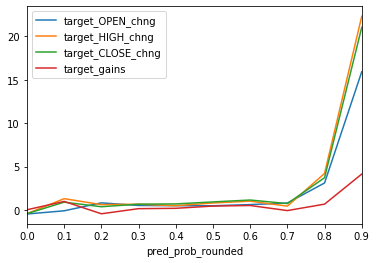

In [91]:
res_see.groupby('pred_prob_rounded').mean()[['target_OPEN_chng', 'target_HIGH_chng', 
                                             'target_CLOSE_chng', 'target_gains']].plot()

In [92]:
res_see.groupby('pred_prob_rounded').mean()[['target_OPEN_chng', 'target_HIGH_chng', 
                                             'target_CLOSE_chng', 'target_gains']]

,target_OPEN_chng,target_HIGH_chng,target_CLOSE_chng,target_gains
pred_prob_rounded,,,,
0.0,-0.446972,-0.407312,-0.407612,0.039885
0.1,-0.076972,1.319469,0.919571,1.003529
0.2,0.838205,0.633869,0.390130,-0.419619
0.3,0.538278,0.681568,0.688898,0.167654
0.4,0.512742,0.512726,0.715148,0.210677
0.5,0.502619,0.822701,0.945658,0.466910
0.6,0.637796,1.035346,1.164796,0.533442
0.7,0.814900,0.457629,0.753751,-0.051574
0.8,3.126858,4.223931,3.732391,0.688425


In [133]:
res_see_agg = res_see.groupby('pred_prob_rounded').mean()[['target_OPEN_chng', 'target_HIGH_chng', 
                                             'target_CLOSE_chng', 'target_gains']]

In [135]:
res_see.loc[(res_see.pred_prob > 0) 
            & (res_see.loc[:,'DTYYYYMMDD'] == '2020-04-15')].sort_values('pred_prob', ascending=False).head(100)

,DTYYYYMMDD,TICKER,OPEN,LOW,HIGH,CLOSE,target,pred_class,target_OPEN_chng,target_HIGH_chng,target_CLOSE_chng,target_gains,pred_prob,pred_prob_rounded
841,2020-04-15,TBULL,14.1000,13.700,16.500,15.9000,1.0,1.0,0.628931,0.000000,2.830189,2.187500,0.861958,0.9
3179,2020-04-15,KOMPUTRON,1.2950,1.285,1.520,1.5100,1.0,1.0,5.298013,30.921053,31.125828,24.528302,0.823620,0.8
1057,2020-04-15,ENTER,25.0000,23.200,27.000,24.8000,0.0,1.0,4.032258,-4.444444,-4.032258,-7.751938,0.822492,0.8
3094,2020-04-15,RAINBOW,15.2000,14.000,16.400,14.9000,1.0,1.0,0.671141,-5.182927,-10.067114,-10.666667,0.820843,0.8
2040,2020-04-15,BIOMEDLUB,2.5800,2.410,3.800,3.8000,1.0,1.0,-10.789474,-2.105263,-11.052632,-0.294985,0.807443,0.8
5465,2020-04-15,TIM,9.5200,9.500,10.350,9.7200,1.0,1.0,0.000000,-0.483092,4.423868,4.423868,0.773835,0.8
1707,2020-04-15,UNIMOT,21.6000,20.700,22.600,22.0000,1.0,1.0,0.000000,2.212389,4.545455,4.545455,0.765069,0.8
3736,2020-04-15,AMREST,30.0000,26.100,31.250,28.7000,1.0,1.0,-0.348432,-7.360000,-8.536585,-8.216783,0.764013,0.8
3026,2020-04-15,ASBIS,3.4000,3.170,3.480,3.1700,1.0,1.0,0.946372,-4.310345,2.208202,1.250000,0.763845,0.8
6371,2020-04-15,MOSTALZAB,0.6580,0.600,0.674,0.6120,1.0,1.0,0.980392,-4.154303,3.267974,2.265372,0.761035,0.8


In [136]:
res_see.loc[(res_see.TICKER.apply(lambda x: True if x in watch else False) & (res_see.loc[:,'DTYYYYMMDD'] == '2020-04-15')),:]

,DTYYYYMMDD,TICKER,OPEN,LOW,HIGH,CLOSE,target,pred_class,target_OPEN_chng,target_HIGH_chng,target_CLOSE_chng,target_gains,pred_prob,pred_prob_rounded
2040,2020-04-15,BIOMEDLUB,2.58,2.410,3.800,3.800,1.0,1.0,-10.789474,-2.105263,-11.052632,-0.294985,0.807443,0.8
3736,2020-04-15,AMREST,30.00,26.100,31.250,28.700,1.0,1.0,-0.348432,-7.360000,-8.536585,-8.216783,0.764013,0.8
2187,2020-04-15,JSW,15.00,13.610,15.185,13.810,0.0,1.0,0.289645,-8.495226,-1.375815,-1.660650,0.753465,0.8
1681,2020-04-15,SUNEX,9.90,9.000,9.980,9.280,1.0,1.0,-0.862069,-4.208417,2.801724,3.695652,0.746404,0.7
5694,2020-04-15,KGHM,76.00,69.520,76.000,70.260,0.0,1.0,1.053231,-5.973684,0.512383,-0.535211,0.727823,0.7
674,2020-04-15,PLAY,33.60,31.700,33.680,31.960,0.0,1.0,1.063830,-4.097387,-1.063830,-2.105263,0.719534,0.7
2478,2020-04-15,PZU,30.99,29.000,31.280,29.020,1.0,1.0,1.585114,-3.612532,3.893866,2.272727,0.719428,0.7
2599,2020-04-15,ARCTIC,4.19,3.800,4.210,3.990,1.0,1.0,1.754386,-1.900238,3.508772,1.724138,0.710754,0.7
3935,2020-04-15,INTERCARS,194.00,178.500,194.000,182.500,1.0,1.0,0.273973,-3.092784,3.013699,2.732240,0.702445,0.7
3068,2020-04-15,WIELTON,4.00,3.800,4.090,3.875,1.0,1.0,-1.032258,-2.444988,0.129032,1.173403,0.699814,0.7


In [261]:
res_std = res_see.groupby('DTYYYYMMDD')\
.mean()[['target_OPEN_chng', 'target_HIGH_chng', 'target_CLOSE_chng', 'pred_prob']]

In [262]:
res_std = (res_std - res_std.mean()) / res_std.std()

In [265]:
res_std.corr()

,target_OPEN_chng,target_HIGH_chng,target_CLOSE_chng,pred_prob
target_OPEN_chng,1.000000,0.747667,0.798805,0.259180
target_HIGH_chng,0.747667,1.000000,0.614235,0.644721
target_CLOSE_chng,0.798805,0.614235,1.000000,0.116755
pred_prob,0.259180,0.644721,0.116755,1.000000


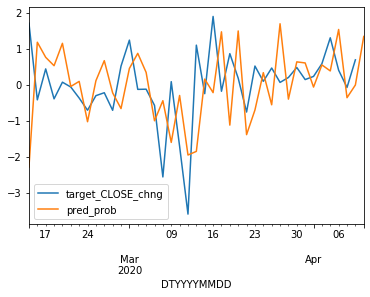

In [264]:
res_std[['target_CLOSE_chng', 'pred_prob']].plot()

In [335]:
df = df_merged.copy()

In [336]:
df.loc[:,'pred_class'] = model.predict(df[train_cols])
df.loc[:,'pred_prob'] = model.predict_proba(df[train_cols])[:,1]

df.loc[:,'fut_OPEN'] = df.loc[:,'OPEN'].shift(-1)
df.loc[:,'target_OPEN_chng'] = (df.loc[:,'fut_OPEN'] * 100 / df.loc[:,'CLOSE']) - 100
df.loc[:,'target_HIGH_chng'] = df.loc[:,'chng_HIGH'].shift(-1).copy()
df.loc[:,'target_CLOSE_chng'] = df.loc[:,'chng_CLOSE'].shift(-1).copy()

In [340]:
res = df.reset_index()

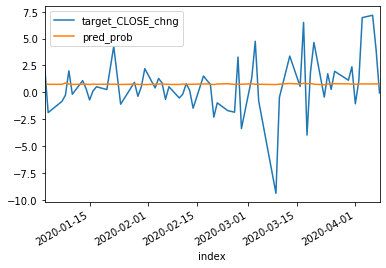

In [354]:
res.loc[(res.loc[:,'index'] > '2020-01-01')
        & (res.pred_prob > 0.7), :].groupby(['index']).mean()[['target_CLOSE_chng', 'pred_prob']].plot()

In [360]:
res.loc[(res.loc[:,'index'] > '2020-01-01')
        & (res.pred_prob > 0.8), :].groupby(['index']).mean()[
    ['target_HIGH_chng','target_CLOSE_chng', 'pred_prob']].median()

target_HIGH_chng     0.202429
target_CLOSE_chng    0.887612
pred_prob            0.833990
dtype: float64

In [355]:
res.sort_values('pred_prob', ascending=False).head(100)

,index,TICKER,OPEN,HIGH,LOW,CLOSE,VOL,OPEN_shifted,chng_OPEN,LOW_shifted,...,target,foreign_stocks_mean,foreign_stocks_max,foreign_stocks_min,pred_class,pred_prob,fut_OPEN,target_OPEN_chng,target_HIGH_chng,target_CLOSE_chng
199145,2011-08-11,PGE,17.85,19.250,17.6500,19.250,6.587300e+06,19.150,-6.788512,17.2400,...,1.0,2.857047,5.404341,-0.952958,1.0,0.967548,949.240,4831.116883,-6.512986,9.040890
541326,2020-03-19,WIG20LEV,228.15,248.410,221.7200,248.410,9.736780e+05,234.310,-2.628996,218.3100,...,1.0,1.330692,7.141789,-5.605968,1.0,0.960654,16.400,-93.398011,-4.576659,1.863354
541325,2020-03-19,PGE,3.65,4.036,3.6200,4.036,7.531181e+06,3.520,3.693182,3.3500,...,1.0,1.330692,7.141789,-5.605968,1.0,0.957879,228.150,5552.874133,0.327141,9.721731
199146,2011-08-11,WIG20LEV,949.24,1014.680,863.6800,1014.680,1.683095e+06,1071.960,-11.448188,878.6300,...,1.0,2.857047,5.404341,-0.952958,1.0,0.955207,84.500,-91.672251,-2.526316,4.360465
541313,2020-03-19,CCC,26.00,29.780,25.4000,29.600,2.128518e+06,26.840,-3.129657,24.3000,...,1.0,1.330692,7.141789,-5.605968,1.0,0.954583,3.000,-89.864865,-3.225806,-3.333333
540604,2020-03-13,LOTOS,42.04,45.900,39.8200,44.990,8.754780e+05,40.500,3.802469,39.0000,...,0.0,3.955261,13.908829,-6.080832,1.0,0.954446,1.870,-95.843521,-2.777778,-2.551020
202290,2011-09-15,CDPROJEKT,3.72,3.950,3.7200,3.950,8.404720e+05,3.650,1.917808,3.6200,...,1.0,1.349585,3.271462,-0.332003,1.0,0.952014,2.520,-36.202532,2.325581,4.761905
540955,2020-03-17,CIGAMES,0.41,0.436,0.4000,0.436,2.820567e+06,0.374,9.625668,0.3370,...,1.0,3.179108,13.518576,-3.209159,1.0,0.950566,10.000,2193.577982,-11.297071,0.200401
541403,2020-03-19,WIG30,1631.13,1712.070,1617.3100,1712.070,1.033160e+06,1635.080,-0.241578,1598.5800,...,1.0,1.330692,7.141789,-5.605968,1.0,0.949328,2977.070,73.887166,3.295832,5.038784
540924,2020-03-17,MABION,25.00,31.000,25.0000,31.000,9.760700e+04,20.000,25.000000,18.5000,...,1.0,3.179108,13.518576,-3.209159,1.0,0.947911,4.960,-84.000000,3.488372,6.024096


In [363]:
res.loc[res.pred_prob > 0.7].mean()

OPEN                    694.408521
HIGH                    706.094534
LOW                     691.763361
CLOSE                   705.061505
VOL                  479465.474154
                         ...      
pred_prob                 0.756463
fut_OPEN                361.378365
target_OPEN_chng       3284.682078
target_HIGH_chng          0.329685
target_CLOSE_chng         0.637524
Length: 276, dtype: float64

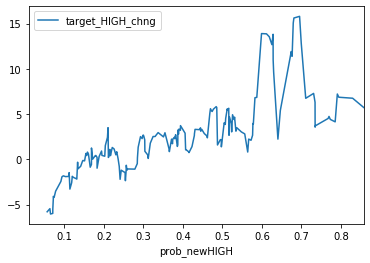

In [162]:
res.loc[:,['target_HIGH_chng', 'prob_newHIGH']]\
.sort_values('prob_newHIGH').set_index('prob_newHIGH').rolling(7).mean().plot()

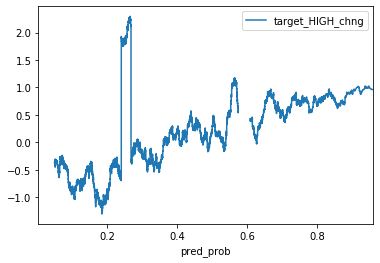

In [375]:
res.loc[res.loc[:,'index'] > '2020-01-01',['target_HIGH_chng', 'pred_prob']]\
.sort_values('pred_prob').set_index('pred_prob').rolling(500).mean().plot()

In [378]:
res.loc[res.loc[:,'index'] > '2020-04-07',:]

,index,TICKER,OPEN,HIGH,LOW,CLOSE,VOL,OPEN_shifted,chng_OPEN,LOW_shifted,...,target,foreign_stocks_mean,foreign_stocks_max,foreign_stocks_min,pred_class,pred_prob,fut_OPEN,target_OPEN_chng,target_HIGH_chng,target_CLOSE_chng
543985,2020-04-08,EFEKT,3.16,3.38,2.86,3.24,21180.0,2.58,22.480620,2.54,...,0.0,1.66631,5.106485,-1.166522,0.0,0.403466,25.70,693.209877,-9.507042,-7.692308
543986,2020-04-08,MABION,25.70,25.70,23.40,24.00,75002.0,28.40,-9.507042,25.65,...,0.0,1.66631,5.106485,-1.166522,0.0,0.242316,2.35,-90.208333,-1.673640,-10.638298
543987,2020-04-08,ELBUDOWA,2.35,2.35,1.91,2.10,129473.0,2.35,0.000000,2.18,...,0.0,1.66631,5.106485,-1.166522,0.0,0.113428,33.50,1495.238095,-10.053476,0.240964
543988,2020-04-08,CCC,33.50,33.64,31.50,33.28,521253.0,35.40,-5.367232,33.20,...,1.0,1.66631,5.106485,-1.166522,1.0,0.599440,2.94,-91.165865,-2.000000,-5.172414
543989,2020-04-08,SOLAR,2.94,2.94,2.65,2.75,10255.0,2.59,13.513514,2.48,...,0.0,1.66631,5.106485,-1.166522,0.0,0.181260,10.20,270.909091,-7.488987,-3.921569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544174,2020-04-08,EVEREST,7.20,7.20,7.00,7.20,1030.0,7.50,-4.000000,7.00,...,0.0,1.66631,5.106485,-1.166522,0.0,0.498369,8.00,11.111111,-0.934579,22.401848
544175,2020-04-08,PHARMENA,8.00,10.60,7.28,10.60,20106.0,10.50,-23.809524,8.52,...,1.0,1.66631,5.106485,-1.166522,1.0,0.701910,3.13,-70.471698,-24.074074,0.000000
544176,2020-04-08,BIOMEDLUB,3.13,4.10,2.64,3.40,9752784.0,5.10,-38.627451,3.33,...,1.0,1.66631,5.106485,-1.166522,1.0,0.529845,3.30,-2.941176,-13.157895,-5.120482
544177,2020-04-08,HARPER,3.30,3.30,2.97,3.15,164611.0,3.70,-10.810811,3.21,...,0.0,1.66631,5.106485,-1.166522,0.0,0.337076,0.27,-91.428571,-3.571429,-3.571429


#### Regression

In [103]:
df.loc[:, 'preds'] = model.predict(df[train_cols])

In [104]:
df.loc[:,['target', 'preds', 'OPEN', 'CLOSE']]

,target,preds,OPEN,CLOSE
DTYYYYMMDD,,,,
2017-07-27,0.027887,0.405700,36.00,35.50
2017-07-28,0.016772,0.115789,35.50,36.25
2017-07-31,0.012212,0.110641,36.37,36.80
2017-08-01,0.024067,0.119130,36.85,36.89
2017-08-02,0.013740,0.046849,36.98,36.50
...,...,...,...,...
2020-04-02,0.049110,0.034687,28.40,28.56
2020-04-03,0.036328,0.037045,28.10,29.48
2020-04-06,0.033443,0.032499,30.28,29.86


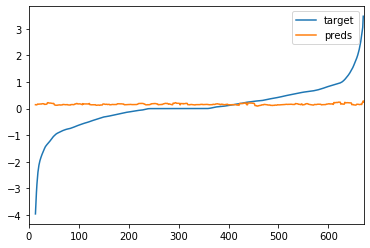

In [220]:
df.sort_values('target').reset_index()[['target', 'preds']].rolling(14).mean().plot()

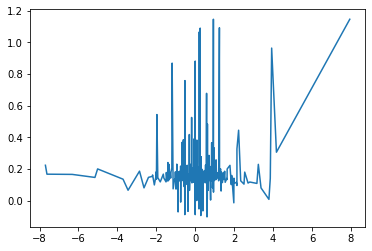

In [210]:
plt.plot(df.sort_values('target').target, df.sort_values('target').preds)

In [191]:
for c in ['preds', 'target']:
    df.loc[df.loc[:, c] > 0, c] = 1
    df.loc[df.loc[:, c] < 1, c] = 0

In [195]:
confusion_matrix(df.target[:-1].astype(int), df.preds[:-1].astype(int))

array([[  6, 351],
       [  6, 308]])

In [196]:
tn, fp, fn, tp = confusion_matrix(df.target[:-1].astype(int), df.preds[:-1].astype(int)).ravel()
(tn, fp, fn, tp)

(6, 351, 6, 308)

In [198]:
df.preds

DTYYYYMMDD
2017-07-27    1.0
2017-07-28    1.0
2017-07-31    1.0
2017-08-01    1.0
2017-08-02    1.0
             ... 
2020-04-02    1.0
2020-04-03    1.0
2020-04-06    1.0
2020-04-07    1.0
2020-04-08    0.0
Name: preds, Length: 672, dtype: float64

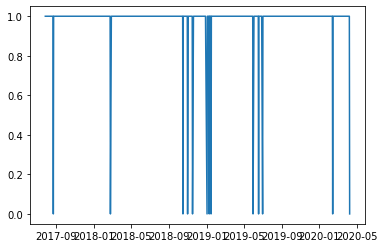

In [197]:
plt.plot(df.preds)

In [ ]:
df_res.loc[:,'one'] = df_res.loc[:,'one'].round(2)
df_res.loc[:,'zero'] = df_res.loc[:,'zero'].round(2)

df_res_grouped = df_res.drop('zero', axis = 1)

df_res_grouped.loc[df_res_grouped.one <= 0.3,'one'] = 0.3

# df_res_grouped.loc[df_res_grouped.one >= 0.54,'one'] = 0.54

df_res_grouped = df_res_grouped.groupby('one').agg(['mean', 'count'])

df_res_grouped.columns = df_res_grouped.columns.get_level_values(1)

df_res_grouped = df_res_grouped.reset_index().set_index('one')

df_res_grouped.plot(secondary_y='count')
plt.xticks(rotation=60)
plt.show()

df_res_grouped

## Foreign indexes

## Other

### Reports

In [42]:
all_reports = pd.read_csv('../bizcrap/fundamental_reports.csv')

In [61]:
cols_to_change = list(all_reports.columns)
cols_to_change[0] = 'Data'
all_reports.columns = cols_to_change

In [45]:
[a for a in all_reports.name.unique() if 'ORLEN' in a]

['raporty-PKN-ORLEN,Q.html']

In [55]:
cols_zysk = [c for c in all_reports.columns if 'zysk' in c]

In [53]:
for c in all_reports.columns:
    all_reports.loc[all_reports.loc[:,c]==-1,c] = np.nan

In [62]:
all_reports.head()

,Data,name,przychody_ze_sprzedaży_main,przychody_ze_sprzedaży_kk,przychody_ze_sprzedaży_sector,techniczny_koszt_wytworzenia_produkcji_sprzedanej_main,techniczny_koszt_wytworzenia_produkcji_sprzedanej_kk,techniczny_koszt_wytworzenia_produkcji_sprzedanej_sector,koszty_sprzedaży_main,koszty_sprzedaży_kk,...,odpisy_netto_z_tytułu_utraty_wartości_kredytów_sector,ogólne_koszty_administracyjne_main,ogólne_koszty_administracyjne_kk,ogólne_koszty_administracyjne_sector,wynik_operacyjny_main,wynik_operacyjny_kk,wynik_operacyjny_sector,udział_w_zyskach_jednostek_podporządkowanych_main,udział_w_zyskach_jednostek_podporządkowanych_kk,udział_w_zyskach_jednostek_podporządkowanych_sector
0,2011/Q1,"raporty-ROKITA,Q.html",282089.0,NaN,NaN,236690.0,NaN,NaN,16740.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011/Q2,"raporty-ROKITA,Q.html",120180.0,-57.40,-6.11,104329.0,-55.92,-7.29,7965.0,-52.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011/Q3,"raporty-ROKITA,Q.html",186398.0,55.10,11.93,163713.0,56.92,4.74,10028.0,25.90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011/Q4,"raporty-ROKITA,Q.html",232250.0,24.60,24.60,184412.0,12.64,12.64,17560.0,75.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2012/Q1,"raporty-ROKITA,Q.html",243002.0,4.63,-7.39,202362.0,9.73,-4.46,13294.0,-24.29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
all_reports.loc[all_reports.name=='raporty-PKN-ORLEN,Q.html',['Data', 'name'] + cols_zysk]

,Data,name,zysk_ze_sprzedaży_main,zysk_ze_sprzedaży_kk,zysk_ze_sprzedaży_sector,zysk_operacyjny_(ebit)_main,zysk_operacyjny_(ebit)_kk,zysk_operacyjny_(ebit)_sector,zysk_z_działalności_gospodarczej_main,zysk_z_działalności_gospodarczej_kk,...,zysk_(strata)_netto_z_działalności_zaniechanej_sector,zysk_netto_main,zysk_netto_kk,zysk_netto_sector,zysk_netto_akcjonariuszy_jednostki_dominującej_main,zysk_netto_akcjonariuszy_jednostki_dominującej_kk,zysk_netto_akcjonariuszy_jednostki_dominującej_sector,udział_w_zyskach_jednostek_podporządkowanych_main,udział_w_zyskach_jednostek_podporządkowanych_kk,udział_w_zyskach_jednostek_podporządkowanych_sector
6856,2005/Q1,"raporty-PKN-ORLEN,Q.html",783503.0,NaN,NaN,797953.0,NaN,NaN,820771.0,NaN,...,NaN,678534.0,NaN,NaN,667527.0,NaN,NaN,NaN,NaN,NaN
6857,2005/Q2,"raporty-PKN-ORLEN,Q.html",1101747.0,40.62,11.69,2615077.0,227.72,9.19,2813959.0,242.84,...,NaN,2565468.0,278.09,38.03,2560212.0,283.54,28.11,NaN,NaN,NaN
6858,2005/Q3,"raporty-PKN-ORLEN,Q.html",1120514.0,1.70,37.29,1090777.0,-58.29,29.90,1221227.0,-56.60,...,NaN,994419.0,-61.24,-0.90,985238.0,-61.52,-0.04,NaN,NaN,NaN
6859,2005/Q4,"raporty-PKN-ORLEN,Q.html",673032.0,-39.94,-24.82,443813.0,-59.31,-34.51,417113.0,-65.84,...,NaN,399355.0,-59.84,-1.46,365479.0,-62.90,-3.24,NaN,NaN,NaN
6860,2006/Q1,"raporty-PKN-ORLEN,Q.html",411141.0,-38.91,33.42,450747.0,1.56,39.40,476236.0,14.17,...,NaN,398153.0,-0.30,49.27,364977.0,-0.14,52.20,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6912,2019/Q1,"raporty-PKN-ORLEN,Q.html",968000.0,86.15,52.80,996000.0,-2.73,31.91,994000.0,2.16,...,NaN,849000.0,37.16,37.16,849000.0,28.25,28.25,NaN,NaN,NaN
6913,2019/Q2,"raporty-PKN-ORLEN,Q.html",1964000.0,102.89,20.46,2086000.0,109.44,52.52,2124000.0,113.68,...,NaN,1601000.0,88.57,62.23,1602000.0,88.69,56.36,NaN,NaN,NaN
6914,2019/Q3,"raporty-PKN-ORLEN,Q.html",1975000.0,0.56,1.69,1807000.0,-13.37,-13.37,1567000.0,-26.22,...,NaN,1266000.0,-20.92,-20.92,1266000.0,-20.97,-23.19,NaN,NaN,NaN
6915,2019/Q4,"raporty-PKN-ORLEN,Q.html",919000.0,-53.47,-16.94,673000.0,-62.76,-32.94,866000.0,-44.74,...,NaN,771000.0,-39.10,-19.55,772000.0,-39.02,-21.16,NaN,NaN,NaN
